In [1]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio.v2 as imageio
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import glob
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense


d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Users\herna\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

# Config GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Importing data

In [6]:
# mport train
df_train = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

## Standarizing data


In [7]:
df_test_full['PHQ8_Binary'] = df_test_full['PHQ_Binary']
df_test_full.drop('PHQ_Binary', axis=1, inplace=True)

In [8]:
df_test_full.head(1)

,Participant_ID,PHQ_Score,Gender,PHQ8_Binary
0,300,2,1,0


In [9]:
df_train.head(1)

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,303,0,0,0,0,0,0.0,0,0,0,0,0


In [10]:
df_dev.head(1)

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0


In [11]:
df_complete = pd.concat([df_test_full, df_dev, df_train], axis=0)

In [12]:
print(f'df_train: {df_train.shape[0]} rows\n'
      f'df_test_full: {df_test_full.shape[0]} rows\n'
      f'df_dev: {df_dev.shape[0]} rows\n'
      f'Total: {df_train.shape[0] + df_test_full.shape[0] + df_dev.shape[0]} rows \n\n'
      
      f'df_complete: {df_complete.shape[0]} rows\n'
      f'df_test: {df_test.shape[0] + df_test.shape[0] + df_test.shape[0]} rows (DISCARD)\n')
      


df_train: 107 rows
df_test_full: 47 rows
df_dev: 35 rows
Total: 189 rows 

df_complete: 189 rows
df_test: 141 rows (DISCARD)



## Visualizing distribution

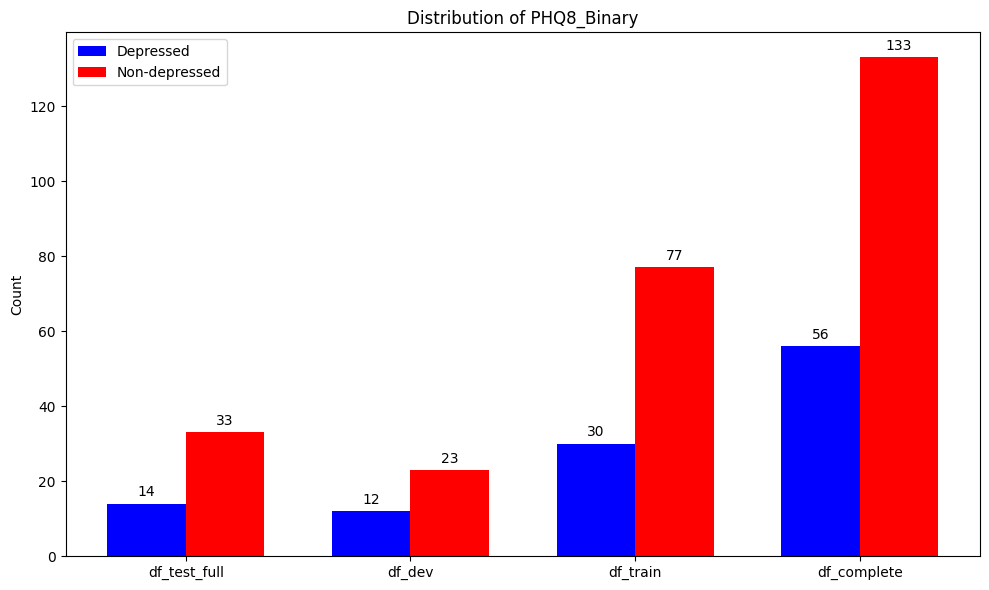

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_phq8_distribution_shared(df_list, titles, labels):
    true_counts = []
    false_counts = []

    for df in df_list:
        true_count = df[df['PHQ8_Binary'] == 1].shape[0]
        false_count = df[df['PHQ8_Binary'] == 0].shape[0]
        true_counts.append(true_count)
        false_counts.append(false_count)
    
    x = np.arange(len(df_list))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, true_counts, width, label=labels[0], color='blue')
    rects2 = ax.bar(x + width/2, false_counts, width, label=labels[1], color='red')

    ax.set_ylabel('Count')
    ax.set_title('Distribution of PHQ8_Binary')
    ax.set_xticks(x)
    ax.set_xticklabels(titles)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Example usage:
plot_phq8_distribution_shared([df_test_full, df_dev, df_train, df_complete], ['df_test_full', 'df_dev', 'df_train', 'df_complete'], ['Depressed', 'Non-depressed'])


# Loading spectrograns

In [33]:
def load_spectrogram(df):
    # Define root path of data
    root_path = 'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/data'  # Replace with your root path

    # Add the column for spectrogram if it doesn't exist
    if 'Spectrogram' not in df.columns:
        # Define the shape of the fixed tensor
        tensor_shape = (292, 252, 3)  # Example shape (height, width, channels)

        # Create a fixed tensor of zeros with the desired shape
        fixed_tensor = np.zeros(tensor_shape, dtype=np.uint8)  # Adjust dtype as needed

        # Initialize the 'Spectrogram' column with the fixed tensor
        df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]

    # Handle missing values in 'Participant_ID' column
    #df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')
    df.loc[:, 'Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')

    # Create an empty list to store modified rows
    modified_rows = []
    for index, row in df.iterrows():
            if not pd.isnull(row['Participant_ID']):  # Check if Participant_ID is not NaN
                participant_id = str(int(row['Participant_ID']))
                folder_path = os.path.join(root_path, str(participant_id) + '_P/resized')
                if os.path.isdir(folder_path):
                    # Flag to check if the first spectrogram has been loaded
                    first_loaded = False
                    # Iterate over image files in the folder
                    for image_file in glob.glob(os.path.join(folder_path, '*.jpg')):
                        image_path = os.path.join(folder_path, image_file)
                        if os.path.isfile(image_path):
                            # If it's the first spectrogram, add it to the original row
                            if not first_loaded:
                                image = imageio.imread(image_path)
                                row['Spectrogram'] = image
                                modified_rows.append(row)  # Add the modified row to the list
                                first_loaded = True
                            else:
                                # Create a copy of the original row
                                new_row = row.copy()
                                # Load the new image
                                new_image = imageio.imread(image_path)
                                # Assign the new image to the 'Spectrogram' column of the new row
                                new_row['Spectrogram'] = new_image
                                # Append the new row to the list
                                modified_rows.append(new_row)
                        else:
                            print(f"Image file not found at path {image_path}. Skipping...")
                else:
                    print(f"Folder not found at path {folder_path}. Skipping...")
                    raise Exception
    # Concatenate the original DataFrame with the modified rows
    #modified_df = pd.concat([df] + modified_rows, ignore_index=True)
    modified_df = pd.DataFrame(modified_rows)
    return modified_df
    #return df


# Making K-fold cross validation

## V1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import os

# Definición del modelo Spectro_CNN en TensorFlow
def create_spectro_cnn(input_shape):   
    input_shape = (252, 792, 3)
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Hiperparámetros
batch_size = 2  # Reducido de 10 a 5
no_epochs = 100
verbosity = 2
k_list = [3, 4, 5, 10]
input_shape = (252, 792, 1)

# Variables para almacenar las medias de los gráficos
mean_accuracy_list = []
mean_loss_list = []
mean_precision_list = []
mean_recall_list = []
mean_specificity_list = []
mean_f1_list = []
mean_auc_list = []

for current_k in k_list:
    # Variables para almacenar las métricas de cada k, para calcular la media al final
    mean_accuracy_per_fold = []
    mean_loss_per_fold = []
    mean_precision_per_fold = []
    mean_recall_per_fold = []
    mean_specificity_per_fold = []
    mean_f1_per_fold = []
    mean_auc_per_fold = []
    
    kfold = KFold(n_splits=current_k, shuffle=True)
    print('------------------------------------------------------------------------')
    print(f'Evaluating for K = {current_k} ...')
    print('------------------------------------------------------------------------')
    
    for fold_no, (train_indices, test_indices) in enumerate(kfold.split(df_complete)):
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no+1} ...')
        
         # Dividir los datos sin aumentar en conjuntos de entrenamiento y prueba
        X_train_unaugmented = df_complete.iloc[train_indices]
        y_train_unaugmented = df_complete.iloc[train_indices]
        X_test_unaugmented = df_complete.iloc[test_indices]
        y_test_unaugmented = df_complete.iloc[test_indices]
        
        # Cargar datos aumentados
        X_train_augmented = load_spectrogram(X_train_unaugmented)
        y_train_augmented = load_spectrogram(y_train_unaugmented)
        X_test_augmented = load_spectrogram(X_test_unaugmented)
        y_test_augmented = load_spectrogram(y_test_unaugmented)
        
        # Reestructurar los dataframes
        X_train = np.array(X_train_augmented['Spectrogram'].tolist())
        y_train = y_train_augmented['PHQ8_Binary'].values
        X_test = np.array(X_test_augmented['Spectrogram'].tolist())
        y_test = y_test_augmented['PHQ8_Binary'].values

        # Definir y compilar el modelo
        model = create_spectro_cnn(input_shape)
        
        # Ajustar el modelo en los datos de entrenamiento aumentados
        model.fit(X_train,
                  y_train, 
                  batch_size=batch_size, 
                  epochs=no_epochs, 
                  verbose=verbosity, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)])
        
        # Evaluar el modelo en los datos de prueba sin aumentar
        scores = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        
        # Aplicar el umbral
        threshold = 0.5
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        
        # Obtener otras métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)
        accuracy = scores[1]
        loss = scores[0]
        
        mean_specificity_per_fold.append(specificity)
        mean_recall_per_fold.append(recall)
        mean_precision_per_fold.append(precision)
        mean_f1_per_fold.append(f1)
        mean_accuracy_per_fold.append(accuracy)
        mean_loss_per_fold.append(loss)
        mean_auc_per_fold.append(auc)
    
    # Calcular las medias
    mean_accuracy = np.mean(mean_accuracy_per_fold)
    mean_loss = np.mean(mean_loss_per_fold)
    mean_precision = np.mean(mean_precision_per_fold)
    mean_recall = np.mean(mean_recall_per_fold)
    mean_specificity = np.mean(mean_specificity_per_fold)
    mean_f1 = np.mean(mean_f1_per_fold)
    mean_auc = np.mean(mean_auc_per_fold)
    
    # Almacenar las medias para el gráfico global
    mean_accuracy_list.append(mean_accuracy)
    mean_loss_list.append(mean_loss)
    mean_precision_list.append(mean_precision)
    mean_recall_list.append(mean_recall)
    mean_specificity_list.append(mean_specificity)
    mean_f1_list.append(mean_f1)
    mean_auc_list.append(mean_auc)

    folder_path = f'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/folds/newPreprocessV2/{current_k}_complete/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Escribir los valores medios en el archivo scores.txt
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean Specificity: {mean_specificity}\n')
        file.write(f'Mean Recall: {mean_recall}\n')
        file.write(f'Mean F1 Score: {mean_f1}\n')
        file.write(f'Mean Accuracy: {mean_accuracy}\n')
        file.write(f'Mean Loss: {mean_loss}\n')
        file.write(f'Mean Precision: {mean_precision}\n')
        file.write(f'Mean AUC: {mean_auc}\n\n')
        file.write(f'True negatives: {tn}\n')
        file.write(f'False negatives: {fn}\n')
        file.write(f'True positives: {tp}\n')
        file.write(f'False positives: {fp}\n')
        
    # Graficar otras métricas
    metrics = ['Specificity', 'Recall', 'F1 Score', 'Accuracy', 'Loss', 'Precision', 'AUC']
    values = [mean_specificity, mean_recall, mean_f1, mean_accuracy, mean_loss, mean_precision, mean_auc]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.title("Model Metrics")
    plt.ylabel("Value")
    plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
    plt.close()

# Graficar resultados globales
plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_accuracy_list, marker='o')
plt.title('Mean Accuracy per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.savefig('mean_accuracy_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_loss_list, marker='o')
plt.title('Mean Loss per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('mean_loss_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_precision_list, marker='o')
plt.title('Mean Precision per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Precision')
plt.grid(True)
plt.savefig('mean_precision_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_recall_list, marker='o')
plt.title('Mean Recall per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Recall')
plt.grid(True)
plt.savefig('mean_recall_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_specificity_list, marker='o')
plt.title('Mean Specificity per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Specificity')
plt.grid(True)
plt.savefig('mean_specificity_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_f1_list, marker='o')
plt.title('Mean F1 Score per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('mean_f1_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_auc_list, marker='o')
plt.title('Mean AUC per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig('mean_auc_per_fold.jpg')
plt.close()


## V2

Capas de Dropout: Se añadieron capas de Dropout después de las capas de MaxPooling para reducir el sobreajuste

Regularización L2: Se añadió regularización L2 a la capa densa para ayudar a prevenir el sobreajuste

Ajuste de Hiperparámetros: Se ajustaron los hiperparámetros como el tamaño del batch y el número de filtros en las capas convolucionales

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import os

# Definición del modelo Spectro_CNN mejorado en TensorFlow
def create_spectro_cnn(input_shape):
    input_shape = (252, 792, 3)
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(8, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model


# Hiperparámetros
batch_size = 5
no_epochs = 100
verbosity = 2
k_list = [3, 4, 5, 10]
input_shape = (252, 792, 1)

# Variables para almacenar las medias de los gráficos
mean_accuracy_list = []
mean_loss_list = []
mean_precision_list = []
mean_recall_list = []
mean_specificity_list = []
mean_f1_list = []
mean_auc_list = []

for current_k in k_list:
    # Variables para almacenar las métricas de cada k, para calcular la media al final
    mean_accuracy_per_fold = []
    mean_loss_per_fold = []
    mean_precision_per_fold = []
    mean_recall_per_fold = []
    mean_specificity_per_fold = []
    mean_f1_per_fold = []
    mean_auc_per_fold = []
    
    kfold = KFold(n_splits=current_k, shuffle=True)
    print('------------------------------------------------------------------------')
    print(f'Evaluating for K = {current_k} ...')
    print('------------------------------------------------------------------------')
    
    for fold_no, (train_indices, test_indices) in enumerate(kfold.split(df_complete)):
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no+1} ...')
        
        
         # Dividir los datos sin aumentar en conjuntos de entrenamiento y prueba
        X_train_unaugmented = df_complete.iloc[train_indices]
        y_train_unaugmented = df_complete.iloc[train_indices]
        X_test_unaugmented = df_complete.iloc[test_indices]
        y_test_unaugmented = df_complete.iloc[test_indices]
        
        # Cargar datos aumentados
        X_train_augmented = load_spectrogram(X_train_unaugmented)
        y_train_augmented = load_spectrogram(y_train_unaugmented)
        X_test_augmented = load_spectrogram(X_test_unaugmented)
        y_test_augmented = load_spectrogram(y_test_unaugmented)
        
        # Reestructurar los dataframes
        X_train = np.array(X_train_augmented['Spectrogram'].tolist())
        y_train = y_train_augmented['PHQ8_Binary'].values
        X_test = np.array(X_test_augmented['Spectrogram'].tolist())
        y_test = y_test_augmented['PHQ8_Binary'].values
        
        # Definir y compilar el modelo
        model = create_spectro_cnn(input_shape)
        
        # Ajustar el modelo en los datos de entrenamiento aumentados
        model.fit(X_train,
                  y_train, 
                  batch_size=batch_size, 
                  epochs=no_epochs, 
                  verbose=verbosity, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)])
        
        # Evaluar el modelo en los datos de prueba sin aumentar
        scores = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        
        # Aplicar el umbral
        threshold = 0.5
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        
        # Obtener otras métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)
        accuracy = scores[1]
        loss = scores[0]
        
        mean_specificity_per_fold.append(specificity)
        mean_recall_per_fold.append(recall)
        mean_precision_per_fold.append(precision)
        mean_f1_per_fold.append(f1)
        mean_accuracy_per_fold.append(accuracy)
        mean_loss_per_fold.append(loss)
        mean_auc_per_fold.append(auc)
    
    # Calcular las medias
    mean_accuracy = np.mean(mean_accuracy_per_fold)
    mean_loss = np.mean(mean_loss_per_fold)
    mean_precision = np.mean(mean_precision_per_fold)
    mean_recall = np.mean(mean_recall_per_fold)
    mean_specificity = np.mean(mean_specificity_per_fold)
    mean_f1 = np.mean(mean_f1_per_fold)
    mean_auc = np.mean(mean_auc_per_fold)
    
    # Almacenar las medias para el gráfico global
    mean_accuracy_list.append(mean_accuracy)
    mean_loss_list.append(mean_loss)
    mean_precision_list.append(mean_precision)
    mean_recall_list.append(mean_recall)
    mean_specificity_list.append(mean_specificity)
    mean_f1_list.append(mean_f1)
    mean_auc_list.append(mean_auc)

    folder_path = f'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/DAIC-WOZ/folds/newPreprocessV2dROPOUT/{current_k}_complete/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Escribir los valores medios en el archivo scores.txt
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean Specificity: {mean_specificity}\n')
        file.write(f'Mean Recall: {mean_recall}\n')
        file.write(f'Mean F1 Score: {mean_f1}\n')
        file.write(f'Mean Accuracy: {mean_accuracy}\n')
        file.write(f'Mean Loss: {mean_loss}\n')
        file.write(f'Mean Precision: {mean_precision}\n')
        file.write(f'Mean AUC: {mean_auc}\n\n')
        file.write(f'True negatives: {tn}\n')
        file.write(f'False negatives: {fn}\n')
        file.write(f'True positives: {tp}\n')
        file.write(f'False positives: {fp}\n')
        
    # Graficar otras métricas
    metrics = ['Specificity', 'Recall', 'F1 Score', 'Accuracy', 'Loss', 'Precision', 'AUC']
    values = [mean_specificity, mean_recall, mean_f1, mean_accuracy, mean_loss, mean_precision, mean_auc]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.title("Model Metrics")
    plt.ylabel("Value")
    plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
    plt.close()

# Graficar resultados globales
plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_accuracy_list, marker='o')
plt.title('Mean Accuracy per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.savefig('mean_accuracy_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_loss_list, marker='o')
plt.title('Mean Loss per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('mean_loss_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_precision_list, marker='o')
plt.title('Mean Precision per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Precision')
plt.grid(True)
plt.savefig('mean_precision_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_recall_list, marker='o')
plt.title('Mean Recall per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Recall')
plt.grid(True)
plt.savefig('mean_recall_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_specificity_list, marker='o')
plt.title('Mean Specificity per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Specificity')
plt.grid(True)
plt.savefig('mean_specificity_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_f1_list, marker='o')
plt.title('Mean F1 Score per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('mean_f1_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_auc_list, marker='o')
plt.title('Mean AUC per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig('mean_auc_per_fold.jpg')
plt.close()


## Normalization

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import os

# Definición del modelo Spectro_CNN mejorado en TensorFlow
def create_spectro_cnn(input_shape):
    input_shape = (252, 792, 3)
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(8, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(64, kernel_regularizer=l2(0.001)))  # Aplicar regularización L2
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model


# Función de normalización Z-score
def normalize_z_score(spectrogram):
    mean = np.mean(spectrogram)
    std = np.std(spectrogram)
    return (spectrogram - mean) / std

# Hiperparámetros
batch_size = 5
no_epochs = 100
verbosity = 2
k_list = [3, 4, 5, 10]
input_shape = (252, 792, 1)

# Variables para almacenar las medias de los gráficos
mean_accuracy_list = []
mean_loss_list = []
mean_precision_list = []
mean_recall_list = []
mean_specificity_list = []
mean_f1_list = []
mean_auc_list = []

for current_k in k_list:
    # Variables para almacenar las métricas de cada k, para calcular la media al final
    mean_accuracy_per_fold = []
    mean_loss_per_fold = []
    mean_precision_per_fold = []
    mean_recall_per_fold = []
    mean_specificity_per_fold = []
    mean_f1_per_fold = []
    mean_auc_per_fold = []
    
    kfold = KFold(n_splits=current_k, shuffle=True)
    print('------------------------------------------------------------------------')
    print(f'Evaluating for K = {current_k} ...')
    print('------------------------------------------------------------------------')
    
    for fold_no, (train_indices, test_indices) in enumerate(kfold.split(df_complete)):
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no+1} ...')
        
         
        # Dividir los datos sin aumentar en conjuntos de entrenamiento y prueba
        X_train_unaugmented = df_complete.iloc[train_indices]
        y_train_unaugmented = df_complete.iloc[train_indices]
        X_test_unaugmented = df_complete.iloc[test_indices]
        y_test_unaugmented = df_complete.iloc[test_indices]
        
        # Cargar datos aumentados
        X_train_augmented = load_spectrogram(X_train_unaugmented)
        y_train_augmented = load_spectrogram(y_train_unaugmented)
        X_test_augmented = load_spectrogram(X_test_unaugmented)
        y_test_augmented = load_spectrogram(y_test_unaugmented)
        
        # Reestructurar los dataframes
        X_train = np.array(X_train_augmented['Spectrogram'].tolist())
        y_train = y_train_augmented['PHQ8_Binary'].values
        X_test = np.array(X_test_augmented['Spectrogram'].tolist())
        y_test = y_test_augmented['PHQ8_Binary'].values
        
        
        # Definir y compilar el modelo
        model = create_spectro_cnn(input_shape = (252, 792, 1))
        
        # Ajustar el modelo en los datos de entrenamiento aumentados
        model.fit(X_train,
                  y_train, 
                  batch_size=batch_size, 
                  epochs=no_epochs, 
                  verbose=verbosity, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)])
        
        # Evaluar el modelo en los datos de prueba sin aumentar
        scores = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        
        # Aplicar el umbral
        threshold = 0.5
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        
        # Obtener otras métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)
        accuracy = scores[1]
        loss = scores[0]
        
        mean_specificity_per_fold.append(specificity)
        mean_recall_per_fold.append(recall)
        mean_precision_per_fold.append(precision)
        mean_f1_per_fold.append(f1)
        mean_accuracy_per_fold.append(accuracy)
        mean_loss_per_fold.append(loss)
        mean_auc_per_fold.append(auc)
    
    # Calcular las medias
    mean_accuracy = np.mean(mean_accuracy_per_fold)
    mean_loss = np.mean(mean_loss_per_fold)
    mean_precision = np.mean(mean_precision_per_fold)
    mean_recall = np.mean(mean_recall_per_fold)
    mean_specificity = np.mean(mean_specificity_per_fold)
    mean_f1 = np.mean(mean_f1_per_fold)
    mean_auc = np.mean(mean_auc_per_fold)
    
    # Almacenar las medias para el gráfico global
    mean_accuracy_list.append(mean_accuracy)
    mean_loss_list.append(mean_loss)
    mean_precision_list.append(mean_precision)
    mean_recall_list.append(mean_recall)
    mean_specificity_list.append(mean_specificity)
    mean_f1_list.append(mean_f1)
    mean_auc_list.append(mean_auc)

    folder_path = f'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/normalized/{current_k}_complete/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Escribir los valores medios en el archivo scores.txt
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean Specificity: {mean_specificity}\n')
        file.write(f'Mean Recall: {mean_recall}\n')
        file.write(f'Mean F1 Score: {mean_f1}\n')
        file.write(f'Mean Accuracy: {mean_accuracy}\n')
        file.write(f'Mean Loss: {mean_loss}\n')
        file.write(f'Mean Precision: {mean_precision}\n')
        file.write(f'Mean AUC: {mean_auc}\n\n')
        file.write(f'True negatives: {tn}\n')
        file.write(f'False negatives: {fn}\n')
        file.write(f'True positives: {tp}\n')
        file.write(f'False positives: {fp}\n')
        
    # Graficar otras métricas
    metrics = ['Specificity', 'Recall', 'F1 Score', 'Accuracy', 'Loss', 'Precision', 'AUC']
    values = [mean_specificity, mean_recall, mean_f1, mean_accuracy, mean_loss, mean_precision, mean_auc]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.title("Model Metrics")
    plt.ylabel("Value")
    plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
    plt.close()

# Graficar resultados globales
plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_accuracy_list, marker='o')
plt.title('Mean Accuracy per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.savefig('mean_accuracy_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_loss_list, marker='o')
plt.title('Mean Loss per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('mean_loss_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_precision_list, marker='o')
plt.title('Mean Precision per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Precision')
plt.grid(True)
plt.savefig('mean_precision_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_recall_list, marker='o')
plt.title('Mean Recall per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Recall')
plt.grid(True)
plt.savefig('mean_recall_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_specificity_list, marker='o')
plt.title('Mean Specificity per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('Specificity')
plt.grid(True)
plt.savefig('mean_specificity_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_f1_list, marker='o')
plt.title('Mean F1 Score per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('mean_f1_per_fold.jpg')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(k_list, mean_auc_list, marker='o')
plt.title('Mean AUC per Fold')
plt.xlabel('Number of Folds')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig('mean_auc_per_fold.jpg')
plt.close()


204/204 - 4s - loss: 0.7660 - accuracy: 0.6980 - 4s/epoch - 22ms/step
Epoch 8/100
204/204 - 4s - loss: 0.8361 - accuracy: 0.6873 - 4s/epoch - 22ms/step
Epoch 9/100
204/204 - 4s - loss: 0.7786 - accuracy: 0.6961 - 4s/epoch - 21ms/step
Epoch 10/100
204/204 - 4s - loss: 0.8012 - accuracy: 0.7000 - 4s/epoch - 22ms/step
4/4 [==============================] - 0s 35ms/step
------------------------------------------------------------------------
Evaluating for fold 7 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1954175115.py:131: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.c

Epoch 1/100
204/204 - 4s - loss: 6.8210 - accuracy: 0.5667 - 4s/epoch - 20ms/step
Epoch 2/100
204/204 - 3s - loss: 1.2182 - accuracy: 0.6039 - 3s/epoch - 17ms/step
Epoch 3/100
204/204 - 3s - loss: 0.9895 - accuracy: 0.6324 - 3s/epoch - 17ms/step
Epoch 4/100
204/204 - 4s - loss: 0.9597 - accuracy: 0.6627 - 4s/epoch - 18ms/step
Epoch 5/100
204/204 - 3s - loss: 0.8590 - accuracy: 0.6833 - 3s/epoch - 16ms/step
Epoch 6/100
204/204 - 3s - loss: 0.8849 - accuracy: 0.6863 - 3s/epoch - 16ms/step
Epoch 7/100
204/204 - 3s - loss: 0.8844 - accuracy: 0.6931 - 3s/epoch - 17ms/step
Epoch 8/100
204/204 - 3s - loss: 0.8151 - accuracy: 0.6961 - 3s/epoch - 16ms/step
Epoch 9/100
204/204 - 5s - loss: 0.8010 - accuracy: 0.6980 - 5s/epoch - 23ms/step
Epoch 10/100
204/204 - 3s - loss: 0.7769 - accuracy: 0.6971 - 3s/epoch - 17ms/step
Epoch 11/100
204/204 - 3s - loss: 0.7672 - accuracy: 0.6961 - 3s/epoch - 17ms/step
Epoch 12/100
204/204 - 3s - loss: 0.7981 - accuracy: 0.7078 - 3s/epoch - 16ms/step
Epoch 13/100


C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Epoch 1/100
204/204 - 4s - loss: 5.9350 - accuracy: 0.6010 - 4s/epoch - 19ms/step
Epoch 2/100
204/204 - 3s - loss: 1.0407 - accuracy: 0.6137 - 3s/epoch - 17ms/step
Epoch 3/100
204/204 - 3s - loss: 0.9715 - accuracy: 0.6539 - 3s/epoch - 16ms/step
Epoch 4/100
204/204 - 3s - loss: 0.8589 - accuracy: 0.6961 - 3s/epoch - 16ms/step
Epoch 5/100
204/204 - 3s - loss: 0.8110 - accuracy: 0.7020 - 3s/epoch - 17ms/step
Epoch 6/100
204/204 - 3s - loss: 0.7609 - accuracy: 0.7088 - 3s/epoch - 16ms/step
Epoch 7/100
204/204 - 3s - loss: 0.7562 - accuracy: 0.7127 - 3s/epoch - 15ms/step
Epoch 8/100
204/204 - 3s - loss: 0.7469 - accuracy: 0.7078 - 3s/epoch - 14ms/step
Epoch 9/100
204/204 - 3s - loss: 0.7981 - accuracy: 0.7118 - 3s/epoch - 14ms/step
Epoch 10/100
204/204 - 3s - loss: 0.8263 - accuracy: 0.7137 - 3s/epoch - 14ms/step
Epoch 11/100
204/204 - 3s - loss: 0.7686 - accuracy: 0.7559 - 3s/epoch - 14ms/step
4/4 [==============================] - 0s 21ms/step
--------------------------------------------

C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Epoch 1/100
204/204 - 5s - loss: 6.8498 - accuracy: 0.5941 - 5s/epoch - 24ms/step
Epoch 2/100
204/204 - 3s - loss: 1.2401 - accuracy: 0.6167 - 3s/epoch - 14ms/step
Epoch 3/100
204/204 - 3s - loss: 1.0087 - accuracy: 0.6461 - 3s/epoch - 14ms/step
Epoch 4/100
204/204 - 3s - loss: 0.9455 - accuracy: 0.6657 - 3s/epoch - 14ms/step
Epoch 5/100
204/204 - 3s - loss: 0.8269 - accuracy: 0.7020 - 3s/epoch - 14ms/step
Epoch 6/100
204/204 - 3s - loss: 0.7782 - accuracy: 0.7000 - 3s/epoch - 16ms/step
Epoch 7/100
204/204 - 4s - loss: 0.7686 - accuracy: 0.6990 - 4s/epoch - 17ms/step
Epoch 8/100
204/204 - 3s - loss: 0.8864 - accuracy: 0.7010 - 3s/epoch - 14ms/step
Epoch 9/100
204/204 - 3s - loss: 0.8023 - accuracy: 0.7078 - 3s/epoch - 13ms/step
Epoch 10/100
204/204 - 3s - loss: 0.7641 - accuracy: 0.7108 - 3s/epoch - 15ms/step
Epoch 11/100
204/204 - 3s - loss: 0.8323 - accuracy: 0.7049 - 3s/epoch - 15ms/step
Epoch 12/100
204/204 - 3s - loss: 0.7517 - accuracy: 0.7275 - 3s/epoch - 14ms/step
Epoch 13/100


C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Epoch 1/100
206/206 - 3s - loss: 5.4946 - accuracy: 0.6043 - 3s/epoch - 17ms/step
Epoch 2/100
206/206 - 3s - loss: 1.1568 - accuracy: 0.6462 - 3s/epoch - 14ms/step
Epoch 3/100
206/206 - 3s - loss: 1.0698 - accuracy: 0.6608 - 3s/epoch - 14ms/step
Epoch 4/100
206/206 - 3s - loss: 0.9326 - accuracy: 0.6481 - 3s/epoch - 14ms/step
Epoch 5/100
206/206 - 3s - loss: 0.8884 - accuracy: 0.6764 - 3s/epoch - 14ms/step
Epoch 6/100
206/206 - 4s - loss: 0.8691 - accuracy: 0.6901 - 4s/epoch - 17ms/step
Epoch 7/100
206/206 - 4s - loss: 0.8416 - accuracy: 0.6930 - 4s/epoch - 18ms/step
Epoch 8/100
206/206 - 3s - loss: 0.8006 - accuracy: 0.7096 - 3s/epoch - 16ms/step
Epoch 9/100
206/206 - 4s - loss: 0.8640 - accuracy: 0.6998 - 4s/epoch - 18ms/step
Epoch 10/100
206/206 - 4s - loss: 0.8011 - accuracy: 0.7076 - 4s/epoch - 17ms/step
Epoch 11/100
206/206 - 3s - loss: 0.7634 - accuracy: 0.7076 - 3s/epoch - 14ms/step
Epoch 12/100
206/206 - 3s - loss: 0.8034 - accuracy: 0.7066 - 3s/epoch - 15ms/step
Epoch 13/100


C:\Users\herna\AppData\Local\Temp\ipykernel_22488\1954175115.py:130: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


## Old exp


In [32]:
# Importar las librerías necesarias
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
import os
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, Adadelta
import tensorflow as tf

# Hiperparámetros
batch_size = 10
no_epochs = 100
verbosity = 2
k_list = [3,4,5,10]
input_shape = (252,792,3)

# Variables para almacenar las medias de los gráficos
mean_accuracy_list = []
mean_loss_list = []
mean_precision_list = []
mean_recall_list = []
mean_specificity_list = []
mean_f1_list = []
mean_auc_list = []

for current_k in k_list:
    # Variables para almacenar las métricas de cada k, para calcular la media al final
    mean_accuracy_per_fold = []
    mean_loss_per_fold = []
    mean_precision_per_fold = []
    mean_recall_per_fold = []
    mean_specificity_per_fold = []
    mean_f1_per_fold = []
    mean_auc_per_fold = []
    
    kfold = KFold(n_splits=current_k, shuffle=True)
    print('------------------------------------------------------------------------')
    print(f'Evaluating for K = {current_k} ...')
    print('------------------------------------------------------------------------')
    
    # División de x e y, usando estratificación para balancear el dataset
    for fold_no, (train_indices, test_indices) in enumerate(kfold.split(df_complete)):
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no+1} ...')
        
        # Dividir los datos sin aumentar en conjuntos de entrenamiento y prueba
        X_train_unaugmented = df_complete.iloc[train_indices]
        y_train_unaugmented = df_complete.iloc[train_indices]
        X_test_unaugmented = df_complete.iloc[test_indices]
        y_test_unaugmented = df_complete.iloc[test_indices]
        
        # Cargar datos aumentados
        X_train_augmented = load_spectrogram(X_train_unaugmented)
        y_train_augmented = load_spectrogram(y_train_unaugmented)
        X_test_augmented = load_spectrogram(X_test_unaugmented)
        y_test_augmented = load_spectrogram(y_test_unaugmented)
        
        # Reestructurar los dataframes
        X_train = np.array(X_train_augmented['Spectrogram'].tolist())
        y_train = y_train_augmented['PHQ8_Binary'].values
        X_test = np.array(X_test_augmented['Spectrogram'].tolist())
        y_test = y_test_augmented['PHQ8_Binary'].values
        print(X_train.shape)
        # Definir y compilar el modelo
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(BatchNormalization())
        model.add(Conv2D(8, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(BatchNormalization())
        model.add(Conv2D(8, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(BatchNormalization())
        model.add(Conv2D(8, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Flatten())
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adadelta', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
        
        # Ajustar el modelo en los datos de entrenamiento aumentados
        model.fit(X_train,
                  y_train, 
                  batch_size=batch_size, 
                  epochs=no_epochs, 
                  verbose=verbosity, callbacks=tf.keras.callbacks.EarlyStopping(
                                            monitor="loss",
                                            min_delta=0.00001,
                                            patience=0,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=False,
                                        ))
        
        # Evaluar el modelo en los datos de prueba sin aumentar
        scores = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        
        # Aplicar el umbral
        threshold = 0.5
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        
        # Obtener otras métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)
        accuracy = scores[1]
        loss = scores[0]
        
        mean_specificity_per_fold.append(specificity)
        mean_recall_per_fold.append(recall)
        mean_precision_per_fold.append(precision)
        mean_f1_per_fold.append(f1)
        mean_accuracy_per_fold.append(accuracy)
        mean_loss_per_fold.append(loss)
        mean_auc_per_fold.append(auc)
    
    # Calcular las medias
    mean_accuracy = np.mean(mean_accuracy_per_fold)
    mean_loss = np.mean(mean_loss_per_fold)
    mean_precision = np.mean(mean_precision_per_fold)
    mean_recall = np.mean(mean_recall_per_fold)
    mean_specificity = np.mean(mean_specificity_per_fold)
    mean_f1 = np.mean(mean_f1_per_fold)
    mean_auc = np.mean(mean_auc_per_fold)
    
    # Almacenar las medias para el gráfico global
    mean_accuracy_list.append(mean_accuracy)
    mean_loss_list.append(mean_loss)
    mean_precision_list.append(mean_precision)
    mean_recall_list.append(mean_recall)
    mean_specificity_list.append(mean_specificity)
    mean_f1_list.append(mean_f1)
    mean_auc_list.append(mean_auc)

    folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/newPreprocessV2/{current_k}_complete/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Escribir los valores medios en el archivo scores.txt
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean Specificity: {mean_specificity}\n')
        file.write(f'Mean Recall: {mean_recall}\n')
        file.write(f'Mean F1 Score: {mean_f1}\n')
        file.write(f'Mean Accuracy: {mean_accuracy}\n')
        file.write(f'Mean Loss: {mean_loss}\n')
        file.write(f'Mean Precision: {mean_precision}\n')
        file.write(f'Mean AUC: {mean_auc}\n\n')
        file.write(f'True negatives: {tn}\n')
        file.write(f'False negatives: {fn}\n')
        file.write(f'True positives: {tp}\n')
        file.write(f'False positives: {fp}\n')
        
    # Graficar otras métricas
    metrics = ['Specificity', 'Recall', 'F1 Score', 'Accuracy', 'Loss', 'Precision', 'AUC']
    values = [mean_specificity, mean_recall, mean_f1, mean_accuracy, mean_loss, mean_precision, mean_auc]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.title("Model Metrics")
    plt.ylabel("Value")
    plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
    plt.close()


------------------------------------------------------------------------
Evaluating for K = 3 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_11956\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_11956\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_11956\1042272723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

(756, 252, 792, 3)
Epoch 1/100


KeyboardInterrupt: 

### Stratified k-folds

In [ ]:
# Importar las librerías necesarias
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
import os
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, Adadelta
import tensorflow as tf

# Hiperparámetros
batch_size = 10
no_epochs = 100
verbosity = 2
k_list = [3,4,5,10]
input_shape = (252,792,3)

# Variables para almacenar las medias de los gráficos
mean_accuracy_list = []
mean_loss_list = []
mean_precision_list = []
mean_recall_list = []
mean_specificity_list = []
mean_f1_list = []
mean_auc_list = []

for current_k in k_list:
    # Variables para almacenar las métricas de cada k, para calcular la media al final
    mean_accuracy_per_fold = []
    mean_loss_per_fold = []
    mean_precision_per_fold = []
    mean_recall_per_fold = []
    mean_specificity_per_fold = []
    mean_f1_per_fold = []
    mean_auc_per_fold = []
    
    kfold = KFold(n_splits=current_k, shuffle=True)
    print('------------------------------------------------------------------------')
    print(f'Evaluating for K = {current_k} ...')
    print('------------------------------------------------------------------------')
    
    # División de x e y, usando estratificación para balancear el dataset
    for fold_no, (train_indices, test_indices) in enumerate(kfold.split(df_complete)):
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no+1} ...')
        
        # Dividir los datos sin aumentar en conjuntos de entrenamiento y prueba
        X_train_unaugmented = df_complete.iloc[train_indices]
        y_train_unaugmented = df_complete.iloc[train_indices]
        X_test_unaugmented = df_complete.iloc[test_indices]
        y_test_unaugmented = df_complete.iloc[test_indices]
        
        # Cargar datos aumentados
        X_train_augmented = load_spectrogram(X_train_unaugmented)
        y_train_augmented = load_spectrogram(y_train_unaugmented)
        X_test_augmented = load_spectrogram(X_test_unaugmented)
        y_test_augmented = load_spectrogram(y_test_unaugmented)
        
        # Reestructurar los dataframes
        X_train = np.array(X_train_augmented['Spectrogram'].tolist())
        y_train = y_train_augmented['PHQ8_Binary'].values
        X_test = np.array(X_test_augmented['Spectrogram'].tolist())
        y_test = y_test_augmented['PHQ8_Binary'].values
        
        # Definir y compilar el modelo
        model = Sequential()
        model.add(BatchNormalization(input_shape=(input_shape)))  # Especifica input_shape
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.5))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adadelta(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

        # Ajustar el modelo en los datos de entrenamiento aumentados
        model.fit(X_train,
            y_train, 
            batch_size=batch_size, 
            epochs=no_epochs, 
            verbose=verbosity, 
            validation_split=0.2,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
            ])
        
        # Evaluar el modelo en los datos de prueba sin aumentar
        scores = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        
        # Aplicar el umbral
        threshold = 0.5
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)
        
        # Obtener otras métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)
        accuracy = scores[1]
        loss = scores[0]
        
        mean_specificity_per_fold.append(specificity)
        mean_recall_per_fold.append(recall)
        mean_precision_per_fold.append(precision)
        mean_f1_per_fold.append(f1)
        mean_accuracy_per_fold.append(accuracy)
        mean_loss_per_fold.append(loss)
        mean_auc_per_fold.append(auc)
    
    # Calcular las medias
    mean_accuracy = np.mean(mean_accuracy_per_fold)
    mean_loss = np.mean(mean_loss_per_fold)
    mean_precision = np.mean(mean_precision_per_fold)
    mean_recall = np.mean(mean_recall_per_fold)
    mean_specificity = np.mean(mean_specificity_per_fold)
    mean_f1 = np.mean(mean_f1_per_fold)
    mean_auc = np.mean(mean_auc_per_fold)
    
    # Almacenar las medias para el gráfico global
    mean_accuracy_list.append(mean_accuracy)
    mean_loss_list.append(mean_loss)
    mean_precision_list.append(mean_precision)
    mean_recall_list.append(mean_recall)
    mean_specificity_list.append(mean_specificity)
    mean_f1_list.append(mean_f1)
    mean_auc_list.append(mean_auc)

    folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/newPreprocessV2/{current_k}_complete/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Escribir los valores medios en el archivo scores.txt
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean Specificity: {mean_specificity}\n')
        file.write(f'Mean Recall: {mean_recall}\n')
        file.write(f'Mean F1 Score: {mean_f1}\n')
        file.write(f'Mean Accuracy: {mean_accuracy}\n')
        file.write(f'Mean Loss: {mean_loss}\n')
        file.write(f'Mean Precision: {mean_precision}\n')
        file.write(f'Mean AUC: {mean_auc}\n\n')
        file.write(f'True negatives: {tn}\n')
        file.write(f'False negatives: {fn}\n')
        file.write(f'True positives: {tp}\n')
        file.write(f'False positives: {fp}\n')
        
    # Graficar otras métricas
    metrics = ['Specificity', 'Recall', 'F1 Score', 'Accuracy', 'Loss', 'Precision', 'AUC']
    values = [mean_specificity, mean_recall, mean_f1, mean_accuracy, mean_loss, mean_precision, mean_auc]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.title("Model Metrics")
    plt.ylabel("Value")
    plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
    plt.close()


------------------------------------------------------------------------
Evaluating for K = 3 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
61/61 - 16s - loss: 0.8201 - accuracy: 0.5960 - val_loss: 0.6103 - val_accuracy: 0.7895 - lr: 0.0010 - 16s/epoch - 259ms/step
Epoch 2/100
61/61 - 14s - loss: 0.6361 - accuracy: 0.6954 - val_loss: 0.5972 - val_accuracy: 0.7829 - lr: 0.0010 - 14s/epoch - 231ms/step
Epoch 3/100
61/61 - 15s - loss: 0.6513 - accuracy: 0.6573 - val_loss: 0.5933 - val_accuracy: 0.7829 - lr: 0.0010 - 15s/epoch - 244ms/step
Epoch 4/100
61/61 - 15s - loss: 0.5824 - accuracy: 0.6937 - val_loss: 0.5566 - val_accuracy: 0.8026 - lr: 0.0010 - 15s/epoch - 246ms/step
Epoch 5/100
61/61 - 9s - loss: 0.5140 - accuracy: 0.7682 - val_loss: 0.5730 - val_accuracy: 0.7566 - lr: 0.0010 - 9s/epoch - 150ms/step
Epoch 6/100
61/61 - 11s - loss: 0.4687 - accuracy: 0.7715 - val_loss: 0.5575 - val_accuracy: 0.7697 - lr: 0.0010 - 11s/epoch - 188ms/step
Epoch 7/100
61/61 - 11s - loss: 0.4022 - accuracy: 0.8096 - val_loss: 0.5671 - val_accuracy: 0.7697 - lr: 0.0010 - 11s/epoch - 173ms/step
Epoch 8/100
61/61 - 10s - loss: 0.37

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
61/61 - 15s - loss: 0.8690 - accuracy: 0.5563 - val_loss: 0.5796 - val_accuracy: 0.8487 - lr: 0.0010 - 15s/epoch - 247ms/step
Epoch 2/100
61/61 - 9s - loss: 0.6565 - accuracy: 0.6540 - val_loss: 0.6156 - val_accuracy: 0.7763 - lr: 0.0010 - 9s/epoch - 156ms/step
Epoch 3/100
61/61 - 9s - loss: 0.5590 - accuracy: 0.7152 - val_loss: 0.5829 - val_accuracy: 0.7895 - lr: 0.0010 - 9s/epoch - 155ms/step
Epoch 4/100
61/61 - 15s - loss: 0.5491 - accuracy: 0.7169 - val_loss: 0.5362 - val_accuracy: 0.8026 - lr: 0.0010 - 15s/epoch - 239ms/step
Epoch 5/100
61/61 - 15s - loss: 0.4668 - accuracy: 0.7682 - val_loss: 0.4787 - val_accuracy: 0.7895 - lr: 0.0010 - 15s/epoch - 244ms/step
Epoch 6/100
61/61 - 15s - loss: 0.4403 - accuracy: 0.7831 - val_loss: 0.4492 - val_accuracy: 0.8224 - lr: 0.0010 - 15s/epoch - 242ms/step
Epoch 7/100
61/61 - 10s - loss: 0.3891 - accuracy: 0.8046 - val_loss: 0.4504 - val_accuracy: 0.8158 - lr: 0.0010 - 10s/epoch - 157ms/step
Epoch 8/100
61/61 - 15s - loss: 0.3357

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy

Epoch 1/100
61/61 - 15s - loss: 0.8577 - accuracy: 0.5844 - val_loss: 0.6626 - val_accuracy: 0.7303 - lr: 0.0010 - 15s/epoch - 249ms/step
Epoch 2/100
61/61 - 15s - loss: 0.6931 - accuracy: 0.6440 - val_loss: 0.6451 - val_accuracy: 0.7895 - lr: 0.0010 - 15s/epoch - 248ms/step
Epoch 3/100
61/61 - 16s - loss: 0.6031 - accuracy: 0.6805 - val_loss: 0.5811 - val_accuracy: 0.8816 - lr: 0.0010 - 16s/epoch - 262ms/step
Epoch 4/100
61/61 - 10s - loss: 0.5450 - accuracy: 0.7152 - val_loss: 0.5887 - val_accuracy: 0.8421 - lr: 0.0010 - 10s/epoch - 170ms/step
Epoch 5/100
61/61 - 19s - loss: 0.5137 - accuracy: 0.7517 - val_loss: 0.5653 - val_accuracy: 0.8355 - lr: 0.0010 - 19s/epoch - 306ms/step
Epoch 6/100
61/61 - 18s - loss: 0.4464 - accuracy: 0.8030 - val_loss: 0.4229 - val_accuracy: 0.9013 - lr: 0.0010 - 18s/epoch - 288ms/step
Epoch 7/100
61/61 - 11s - loss: 0.3875 - accuracy: 0.8162 - val_loss: 0.4277 - val_accuracy: 0.8684 - lr: 0.0010 - 11s/epoch - 185ms/step
Epoch 8/100
61/61 - 11s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
68/68 - 15s - loss: 0.9413 - accuracy: 0.5636 - val_loss: 0.6440 - val_accuracy: 0.8059 - lr: 0.0010 - 15s/epoch - 222ms/step
Epoch 2/100
68/68 - 9s - loss: 0.7159 - accuracy: 0.6420 - val_loss: 0.6547 - val_accuracy: 0.6882 - lr: 0.0010 - 9s/epoch - 136ms/step
Epoch 3/100
68/68 - 14s - loss: 0.6453 - accuracy: 0.6598 - val_loss: 0.5636 - val_accuracy: 0.8529 - lr: 0.0010 - 14s/epoch - 209ms/step
Epoch 4/100
68/68 - 14s - loss: 0.6066 - accuracy: 0.6805 - val_loss: 0.5511 - val_accuracy: 0.8059 - lr: 0.0010 - 14s/epoch - 208ms/step
Epoch 5/100
68/68 - 14s - loss: 0.5051 - accuracy: 0.7618 - val_loss: 0.4923 - val_accuracy: 0.8529 - lr: 0.0010 - 14s/epoch - 209ms/step
Epoch 6/100
68/68 - 9s - loss: 0.4524 - accuracy: 0.7959 - val_loss: 0.5006 - val_accuracy: 0.8294 - lr: 0.0010 - 9s/epoch - 137ms/step
Epoch 7/100
68/68 - 14s - loss: 0.4029 - accuracy: 0.8240 - val_loss: 0.4539 - val_accuracy: 0.8471 - lr: 0.0010 - 14s/epoch - 211ms/step
Epoch 8/100
68/68 - 15s - loss: 0.3486

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
69/69 - 19s - loss: 0.8762 - accuracy: 0.5668 - val_loss: 0.6498 - val_accuracy: 0.6959 - lr: 0.0010 - 19s/epoch - 269ms/step
Epoch 2/100
69/69 - 16s - loss: 0.6551 - accuracy: 0.6505 - val_loss: 0.6086 - val_accuracy: 0.7602 - lr: 0.0010 - 16s/epoch - 227ms/step
Epoch 3/100
69/69 - 16s - loss: 0.6048 - accuracy: 0.6784 - val_loss: 0.5657 - val_accuracy: 0.7895 - lr: 0.0010 - 16s/epoch - 237ms/step
Epoch 4/100
69/69 - 10s - loss: 0.5464 - accuracy: 0.7181 - val_loss: 0.5673 - val_accuracy: 0.7895 - lr: 0.0010 - 10s/epoch - 144ms/step
Epoch 5/100
69/69 - 15s - loss: 0.5281 - accuracy: 0.7254 - val_loss: 0.5372 - val_accuracy: 0.7895 - lr: 0.0010 - 15s/epoch - 212ms/step
Epoch 6/100
69/69 - 10s - loss: 0.4596 - accuracy: 0.7665 - val_loss: 0.5597 - val_accuracy: 0.7719 - lr: 0.0010 - 10s/epoch - 147ms/step
Epoch 7/100
69/69 - 15s - loss: 0.4356 - accuracy: 0.7871 - val_loss: 0.5289 - val_accuracy: 0.7895 - lr: 0.0010 - 15s/epoch - 219ms/step
Epoch 8/100
69/69 - 10s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
69/69 - 17s - loss: 0.9284 - accuracy: 0.5727 - val_loss: 0.5538 - val_accuracy: 0.8596 - lr: 0.0010 - 17s/epoch - 240ms/step
Epoch 2/100
69/69 - 16s - loss: 0.7071 - accuracy: 0.6564 - val_loss: 0.5311 - val_accuracy: 0.8596 - lr: 0.0010 - 16s/epoch - 228ms/step
Epoch 3/100
69/69 - 16s - loss: 0.6339 - accuracy: 0.6784 - val_loss: 0.5139 - val_accuracy: 0.8421 - lr: 0.0010 - 16s/epoch - 229ms/step
Epoch 4/100
69/69 - 15s - loss: 0.5771 - accuracy: 0.7004 - val_loss: 0.5053 - val_accuracy: 0.8246 - lr: 0.0010 - 15s/epoch - 220ms/step
Epoch 5/100
69/69 - 16s - loss: 0.4806 - accuracy: 0.7665 - val_loss: 0.4886 - val_accuracy: 0.8363 - lr: 0.0010 - 16s/epoch - 228ms/step
Epoch 6/100
69/69 - 11s - loss: 0.4515 - accuracy: 0.7812 - val_loss: 0.5313 - val_accuracy: 0.8012 - lr: 0.0010 - 11s/epoch - 152ms/step
Epoch 7/100
69/69 - 10s - loss: 0.3857 - accuracy: 0.8385 - val_loss: 0.5071 - val_accuracy: 0.8129 - lr: 0.0010 - 10s/epoch - 148ms/step
Epoch 8/100
69/69 - 11s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
69/69 - 15s - loss: 0.8692 - accuracy: 0.5668 - val_loss: 0.5417 - val_accuracy: 0.9123 - lr: 0.0010 - 15s/epoch - 224ms/step
Epoch 2/100
69/69 - 10s - loss: 0.7042 - accuracy: 0.6417 - val_loss: 0.6645 - val_accuracy: 0.7076 - lr: 0.0010 - 10s/epoch - 143ms/step
Epoch 3/100
69/69 - 10s - loss: 0.6339 - accuracy: 0.6711 - val_loss: 0.6380 - val_accuracy: 0.7602 - lr: 0.0010 - 10s/epoch - 145ms/step
Epoch 4/100
69/69 - 10s - loss: 0.5448 - accuracy: 0.7225 - val_loss: 0.5585 - val_accuracy: 0.8129 - lr: 0.0010 - 10s/epoch - 148ms/step
Epoch 5/100
69/69 - 10s - loss: 0.5351 - accuracy: 0.7327 - val_loss: 0.5451 - val_accuracy: 0.8129 - lr: 1.0000e-04 - 10s/epoch - 149ms/step
Epoch 6/100
69/69 - 15s - loss: 0.5416 - accuracy: 0.7166 - val_loss: 0.5251 - val_accuracy: 0.8070 - lr: 1.0000e-04 - 15s/epoch - 222ms/step
Epoch 7/100
69/69 - 15s - loss: 0.5140 - accuracy: 0.7518 - val_loss: 0.5168 - val_accuracy: 0.8012 - lr: 1.0000e-04 - 15s/epoch - 221ms/step
Epoch 8/100
69/69 - 15

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
73/73 - 17s - loss: 0.8767 - accuracy: 0.6050 - val_loss: 0.5778 - val_accuracy: 0.8516 - lr: 0.0010 - 17s/epoch - 228ms/step
Epoch 2/100
73/73 - 18s - loss: 0.7459 - accuracy: 0.6064 - val_loss: 0.5566 - val_accuracy: 0.8187 - lr: 0.0010 - 18s/epoch - 247ms/step
Epoch 3/100
73/73 - 11s - loss: 0.6690 - accuracy: 0.6478 - val_loss: 0.5849 - val_accuracy: 0.7692 - lr: 0.0010 - 11s/epoch - 150ms/step
Epoch 4/100
73/73 - 11s - loss: 0.5841 - accuracy: 0.6796 - val_loss: 0.5652 - val_accuracy: 0.7747 - lr: 0.0010 - 11s/epoch - 153ms/step
Epoch 5/100
73/73 - 16s - loss: 0.5441 - accuracy: 0.7251 - val_loss: 0.5396 - val_accuracy: 0.7967 - lr: 0.0010 - 16s/epoch - 217ms/step
Epoch 6/100
73/73 - 16s - loss: 0.5138 - accuracy: 0.7555 - val_loss: 0.4770 - val_accuracy: 0.8297 - lr: 0.0010 - 16s/epoch - 220ms/step
Epoch 7/100
73/73 - 17s - loss: 0.4338 - accuracy: 0.7942 - val_loss: 0.4642 - val_accuracy: 0.8681 - lr: 0.0010 - 17s/epoch - 226ms/step
Epoch 8/100
73/73 - 16s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
73/73 - 16s - loss: 0.8759 - accuracy: 0.5677 - val_loss: 0.5814 - val_accuracy: 0.8297 - lr: 0.0010 - 16s/epoch - 223ms/step
Epoch 2/100
73/73 - 16s - loss: 0.6686 - accuracy: 0.6575 - val_loss: 0.5779 - val_accuracy: 0.7857 - lr: 0.0010 - 16s/epoch - 219ms/step
Epoch 3/100
73/73 - 11s - loss: 0.5695 - accuracy: 0.7141 - val_loss: 0.5908 - val_accuracy: 0.7253 - lr: 0.0010 - 11s/epoch - 146ms/step
Epoch 4/100
73/73 - 16s - loss: 0.5273 - accuracy: 0.7334 - val_loss: 0.5456 - val_accuracy: 0.7802 - lr: 0.0010 - 16s/epoch - 216ms/step
Epoch 5/100
73/73 - 16s - loss: 0.4849 - accuracy: 0.7597 - val_loss: 0.5429 - val_accuracy: 0.7692 - lr: 0.0010 - 16s/epoch - 221ms/step
Epoch 6/100
73/73 - 11s - loss: 0.4542 - accuracy: 0.7942 - val_loss: 0.5666 - val_accuracy: 0.7582 - lr: 0.0010 - 11s/epoch - 151ms/step
Epoch 7/100
73/73 - 11s - loss: 0.3593 - accuracy: 0.8315 - val_loss: 0.5806 - val_accuracy: 0.7473 - lr: 0.0010 - 11s/epoch - 146ms/step
Epoch 8/100
73/73 - 11s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
73/73 - 20s - loss: 0.9529 - accuracy: 0.5249 - val_loss: 0.7056 - val_accuracy: 0.4286 - lr: 0.0010 - 20s/epoch - 273ms/step
Epoch 2/100
73/73 - 17s - loss: 0.6468 - accuracy: 0.6699 - val_loss: 0.6851 - val_accuracy: 0.5495 - lr: 0.0010 - 17s/epoch - 238ms/step
Epoch 3/100
73/73 - 18s - loss: 0.6184 - accuracy: 0.6492 - val_loss: 0.6450 - val_accuracy: 0.6813 - lr: 0.0010 - 18s/epoch - 242ms/step
Epoch 4/100
73/73 - 17s - loss: 0.5339 - accuracy: 0.7472 - val_loss: 0.6137 - val_accuracy: 0.6978 - lr: 0.0010 - 17s/epoch - 237ms/step
Epoch 5/100
73/73 - 18s - loss: 0.4938 - accuracy: 0.7514 - val_loss: 0.5504 - val_accuracy: 0.7747 - lr: 0.0010 - 18s/epoch - 245ms/step
Epoch 6/100
73/73 - 16s - loss: 0.4548 - accuracy: 0.7845 - val_loss: 0.5473 - val_accuracy: 0.7912 - lr: 0.0010 - 16s/epoch - 226ms/step
Epoch 7/100
73/73 - 12s - loss: 0.4101 - accuracy: 0.7997 - val_loss: 0.5779 - val_accuracy: 0.7637 - lr: 0.0010 - 12s/epoch - 169ms/step
Epoch 8/100
73/73 - 11s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy

Epoch 1/100
73/73 - 17s - loss: 0.8174 - accuracy: 0.6036 - val_loss: 0.5858 - val_accuracy: 0.8352 - lr: 0.0010 - 17s/epoch - 230ms/step
Epoch 2/100
73/73 - 17s - loss: 0.6581 - accuracy: 0.6381 - val_loss: 0.5835 - val_accuracy: 0.8352 - lr: 0.0010 - 17s/epoch - 239ms/step
Epoch 3/100
73/73 - 17s - loss: 0.5989 - accuracy: 0.6906 - val_loss: 0.5548 - val_accuracy: 0.8352 - lr: 0.0010 - 17s/epoch - 239ms/step
Epoch 4/100
73/73 - 17s - loss: 0.5228 - accuracy: 0.7445 - val_loss: 0.5344 - val_accuracy: 0.8242 - lr: 0.0010 - 17s/epoch - 228ms/step
Epoch 5/100
73/73 - 17s - loss: 0.4829 - accuracy: 0.7680 - val_loss: 0.5316 - val_accuracy: 0.8077 - lr: 0.0010 - 17s/epoch - 234ms/step
Epoch 6/100
73/73 - 17s - loss: 0.4109 - accuracy: 0.7859 - val_loss: 0.5151 - val_accuracy: 0.8077 - lr: 0.0010 - 17s/epoch - 227ms/step
Epoch 7/100
73/73 - 12s - loss: 0.3758 - accuracy: 0.8343 - val_loss: 0.5314 - val_accuracy: 0.8077 - lr: 0.0010 - 12s/epoch - 167ms/step
Epoch 8/100
73/73 - 11s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
73/73 - 17s - loss: 0.8748 - accuracy: 0.5638 - val_loss: 0.5291 - val_accuracy: 0.8689 - lr: 0.0010 - 17s/epoch - 229ms/step
Epoch 2/100
73/73 - 16s - loss: 0.6787 - accuracy: 0.6543 - val_loss: 0.5176 - val_accuracy: 0.8689 - lr: 0.0010 - 16s/epoch - 217ms/step
Epoch 3/100
73/73 - 10s - loss: 0.6322 - accuracy: 0.6927 - val_loss: 0.5884 - val_accuracy: 0.7869 - lr: 0.0010 - 10s/epoch - 142ms/step
Epoch 4/100
73/73 - 10s - loss: 0.5464 - accuracy: 0.7311 - val_loss: 0.5758 - val_accuracy: 0.7923 - lr: 0.0010 - 10s/epoch - 141ms/step
Epoch 5/100
73/73 - 10s - loss: 0.5420 - accuracy: 0.7215 - val_loss: 0.5734 - val_accuracy: 0.7869 - lr: 0.0010 - 10s/epoch - 143ms/step
Epoch 6/100
73/73 - 11s - loss: 0.4733 - accuracy: 0.7586 - val_loss: 0.5605 - val_accuracy: 0.7978 - lr: 1.0000e-04 - 11s/epoch - 147ms/step
Epoch 7/100
73/73 - 11s - loss: 0.4647 - accuracy: 0.7888 - val_loss: 0.5442 - val_accuracy: 0.8142 - lr: 1.0000e-04 - 11s/epoch - 153ms/step
7/7 [=====================

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))

Epoch 1/100
82/82 - 18s - loss: 0.8669 - accuracy: 0.5502 - val_loss: 0.6145 - val_accuracy: 0.8627 - lr: 0.0010 - 18s/epoch - 219ms/step
Epoch 2/100
82/82 - 17s - loss: 0.6332 - accuracy: 0.6532 - val_loss: 0.5500 - val_accuracy: 0.8873 - lr: 0.0010 - 17s/epoch - 210ms/step
Epoch 3/100
82/82 - 17s - loss: 0.6321 - accuracy: 0.6740 - val_loss: 0.5299 - val_accuracy: 0.8676 - lr: 0.0010 - 17s/epoch - 211ms/step
Epoch 4/100
82/82 - 17s - loss: 0.6153 - accuracy: 0.6642 - val_loss: 0.5276 - val_accuracy: 0.8627 - lr: 0.0010 - 17s/epoch - 211ms/step
Epoch 5/100
82/82 - 17s - loss: 0.5740 - accuracy: 0.7132 - val_loss: 0.5258 - val_accuracy: 0.8235 - lr: 0.0010 - 17s/epoch - 204ms/step
Epoch 6/100
82/82 - 18s - loss: 0.4952 - accuracy: 0.7574 - val_loss: 0.4412 - val_accuracy: 0.8578 - lr: 0.0010 - 18s/epoch - 215ms/step
Epoch 7/100
82/82 - 17s - loss: 0.4547 - accuracy: 0.7880 - val_loss: 0.4406 - val_accuracy: 0.8627 - lr: 0.0010 - 17s/epoch - 202ms/step
Epoch 8/100
82/82 - 12s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy

Epoch 1/100
82/82 - 18s - loss: 0.8099 - accuracy: 0.6005 - val_loss: 0.5334 - val_accuracy: 0.8529 - lr: 0.0010 - 18s/epoch - 217ms/step
Epoch 2/100
82/82 - 12s - loss: 0.6713 - accuracy: 0.6495 - val_loss: 0.5345 - val_accuracy: 0.8529 - lr: 0.0010 - 12s/epoch - 146ms/step
Epoch 3/100
82/82 - 11s - loss: 0.5945 - accuracy: 0.6863 - val_loss: 0.6377 - val_accuracy: 0.6863 - lr: 0.0010 - 11s/epoch - 138ms/step
Epoch 4/100
82/82 - 11s - loss: 0.5618 - accuracy: 0.7010 - val_loss: 0.5600 - val_accuracy: 0.7843 - lr: 0.0010 - 11s/epoch - 137ms/step
Epoch 5/100
82/82 - 1428s - loss: 0.5319 - accuracy: 0.7512 - val_loss: 0.5528 - val_accuracy: 0.7745 - lr: 1.0000e-04 - 1428s/epoch - 17s/step
Epoch 6/100
82/82 - 88s - loss: 0.4656 - accuracy: 0.7806 - val_loss: 0.5347 - val_accuracy: 0.7843 - lr: 1.0000e-04 - 88s/epoch - 1s/step
4/4 [==============================] - 2s 766ms/step


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]


------------------------------------------------------------------------
Evaluating for fold 3 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
82/82 - 186s - loss: 0.8585 - accuracy: 0.5797 - val_loss: 0.5846 - val_accuracy: 0.8480 - lr: 0.0010 - 186s/epoch - 2s/step
Epoch 2/100
82/82 - 51s - loss: 0.6860 - accuracy: 0.6532 - val_loss: 0.5499 - val_accuracy: 0.8431 - lr: 0.0010 - 51s/epoch - 626ms/step
Epoch 3/100
82/82 - 50s - loss: 0.6018 - accuracy: 0.6961 - val_loss: 0.5292 - val_accuracy: 0.8186 - lr: 0.0010 - 50s/epoch - 614ms/step
Epoch 4/100
82/82 - 19s - loss: 0.5490 - accuracy: 0.7365 - val_loss: 0.5273 - val_accuracy: 0.8088 - lr: 0.0010 - 19s/epoch - 230ms/step
Epoch 5/100
82/82 - 19s - loss: 0.5264 - accuracy: 0.7292 - val_loss: 0.5185 - val_accuracy: 0.8088 - lr: 0.0010 - 19s/epoch - 229ms/step
Epoch 6/100
82/82 - 19s - loss: 0.4768 - accuracy: 0.7819 - val_loss: 0.4996 - val_accuracy: 0.8088 - lr: 0.0010 - 19s/epoch - 229ms/step
Epoch 7/100
82/82 - 13s - loss: 0.4023 - accuracy: 0.8076 - val_loss: 0.5048 - val_accuracy: 0.7892 - lr: 0.0010 - 13s/epoch - 160ms/step
Epoch 8/100
82/82 - 18s - loss: 0.3

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
82/82 - 20s - loss: 0.8207 - accuracy: 0.5821 - val_loss: 0.6462 - val_accuracy: 0.7990 - lr: 0.0010 - 20s/epoch - 242ms/step
Epoch 2/100
82/82 - 19s - loss: 0.6597 - accuracy: 0.6348 - val_loss: 0.6310 - val_accuracy: 0.8088 - lr: 0.0010 - 19s/epoch - 234ms/step
Epoch 3/100
82/82 - 18s - loss: 0.5871 - accuracy: 0.7010 - val_loss: 0.5954 - val_accuracy: 0.8039 - lr: 0.0010 - 18s/epoch - 225ms/step
Epoch 4/100
82/82 - 19s - loss: 0.5393 - accuracy: 0.7341 - val_loss: 0.5431 - val_accuracy: 0.8235 - lr: 0.0010 - 19s/epoch - 229ms/step
Epoch 5/100
82/82 - 18s - loss: 0.4842 - accuracy: 0.7512 - val_loss: 0.5028 - val_accuracy: 0.8333 - lr: 0.0010 - 18s/epoch - 225ms/step
Epoch 6/100
82/82 - 19s - loss: 0.4539 - accuracy: 0.7880 - val_loss: 0.4983 - val_accuracy: 0.8333 - lr: 0.0010 - 19s/epoch - 229ms/step
Epoch 7/100
82/82 - 13s - loss: 0.4032 - accuracy: 0.8223 - val_loss: 0.5055 - val_accuracy: 0.8186 - lr: 0.0010 - 13s/epoch - 162ms/step
Epoch 8/100
82/82 - 13s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
82/82 - 19s - loss: 0.9217 - accuracy: 0.5502 - val_loss: 0.5578 - val_accuracy: 0.8676 - lr: 0.0010 - 19s/epoch - 234ms/step
Epoch 2/100
82/82 - 13s - loss: 0.7092 - accuracy: 0.6446 - val_loss: 0.6001 - val_accuracy: 0.8137 - lr: 0.0010 - 13s/epoch - 160ms/step
Epoch 3/100
82/82 - 13s - loss: 0.6156 - accuracy: 0.6740 - val_loss: 0.5863 - val_accuracy: 0.8382 - lr: 0.0010 - 13s/epoch - 159ms/step
Epoch 4/100
82/82 - 18s - loss: 0.5582 - accuracy: 0.7120 - val_loss: 0.5287 - val_accuracy: 0.8284 - lr: 0.0010 - 18s/epoch - 217ms/step
Epoch 5/100
82/82 - 13s - loss: 0.5033 - accuracy: 0.7684 - val_loss: 0.5475 - val_accuracy: 0.7794 - lr: 0.0010 - 13s/epoch - 164ms/step
Epoch 6/100
82/82 - 19s - loss: 0.4534 - accuracy: 0.7770 - val_loss: 0.5247 - val_accuracy: 0.7794 - lr: 0.0010 - 19s/epoch - 228ms/step
Epoch 7/100
82/82 - 20s - loss: 0.3998 - accuracy: 0.8162 - val_loss: 0.4648 - val_accuracy: 0.8382 - lr: 0.0010 - 20s/epoch - 240ms/step
Epoch 8/100
82/82 - 13s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
82/82 - 36s - loss: 0.9118 - accuracy: 0.5270 - val_loss: 0.6382 - val_accuracy: 0.8627 - lr: 0.0010 - 36s/epoch - 436ms/step
Epoch 2/100
82/82 - 36s - loss: 0.6789 - accuracy: 0.6397 - val_loss: 0.5972 - val_accuracy: 0.8676 - lr: 0.0010 - 36s/epoch - 437ms/step
Epoch 3/100
82/82 - 37s - loss: 0.6468 - accuracy: 0.6642 - val_loss: 0.5490 - val_accuracy: 0.8676 - lr: 0.0010 - 37s/epoch - 446ms/step
Epoch 4/100
82/82 - 13s - loss: 0.6170 - accuracy: 0.6826 - val_loss: 0.5604 - val_accuracy: 0.8235 - lr: 0.0010 - 13s/epoch - 164ms/step
Epoch 5/100
82/82 - 37s - loss: 0.5431 - accuracy: 0.7157 - val_loss: 0.4948 - val_accuracy: 0.8824 - lr: 0.0010 - 37s/epoch - 446ms/step
Epoch 6/100
82/82 - 13s - loss: 0.5142 - accuracy: 0.7549 - val_loss: 0.5062 - val_accuracy: 0.8529 - lr: 0.0010 - 13s/epoch - 163ms/step
Epoch 7/100
82/82 - 13s - loss: 0.4601 - accuracy: 0.7843 - val_loss: 0.5089 - val_accuracy: 0.8333 - lr: 0.0010 - 13s/epoch - 160ms/step
Epoch 8/100
82/82 - 35s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy

Epoch 1/100
82/82 - 35s - loss: 1.0398 - accuracy: 0.4988 - val_loss: 0.6244 - val_accuracy: 0.7843 - lr: 0.0010 - 35s/epoch - 422ms/step
Epoch 2/100
82/82 - 13s - loss: 0.7389 - accuracy: 0.6164 - val_loss: 0.6293 - val_accuracy: 0.7500 - lr: 0.0010 - 13s/epoch - 162ms/step
Epoch 3/100
82/82 - 35s - loss: 0.6541 - accuracy: 0.6409 - val_loss: 0.6111 - val_accuracy: 0.7843 - lr: 0.0010 - 35s/epoch - 428ms/step
Epoch 4/100
82/82 - 35s - loss: 0.6170 - accuracy: 0.6605 - val_loss: 0.5756 - val_accuracy: 0.7990 - lr: 0.0010 - 35s/epoch - 432ms/step
Epoch 5/100
82/82 - 34s - loss: 0.5572 - accuracy: 0.6998 - val_loss: 0.5149 - val_accuracy: 0.8382 - lr: 0.0010 - 34s/epoch - 409ms/step
Epoch 6/100
82/82 - 37s - loss: 0.5595 - accuracy: 0.7243 - val_loss: 0.5092 - val_accuracy: 0.8333 - lr: 0.0010 - 37s/epoch - 446ms/step
Epoch 7/100
82/82 - 36s - loss: 0.4909 - accuracy: 0.7475 - val_loss: 0.4478 - val_accuracy: 0.8578 - lr: 0.0010 - 36s/epoch - 433ms/step
Epoch 8/100
82/82 - 13s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy

Epoch 1/100
82/82 - 37s - loss: 0.8225 - accuracy: 0.5833 - val_loss: 0.5653 - val_accuracy: 0.8382 - lr: 0.0010 - 37s/epoch - 449ms/step
Epoch 2/100
82/82 - 35s - loss: 0.6346 - accuracy: 0.6630 - val_loss: 0.5542 - val_accuracy: 0.8137 - lr: 0.0010 - 35s/epoch - 423ms/step
Epoch 3/100
82/82 - 36s - loss: 0.6101 - accuracy: 0.6789 - val_loss: 0.5509 - val_accuracy: 0.7941 - lr: 0.0010 - 36s/epoch - 437ms/step
Epoch 4/100
82/82 - 12s - loss: 0.5378 - accuracy: 0.7402 - val_loss: 0.5539 - val_accuracy: 0.7892 - lr: 0.0010 - 12s/epoch - 146ms/step
Epoch 5/100
82/82 - 35s - loss: 0.4829 - accuracy: 0.7696 - val_loss: 0.5269 - val_accuracy: 0.8039 - lr: 0.0010 - 35s/epoch - 430ms/step
Epoch 6/100
82/82 - 12s - loss: 0.4430 - accuracy: 0.7941 - val_loss: 0.5441 - val_accuracy: 0.7843 - lr: 0.0010 - 12s/epoch - 145ms/step
Epoch 7/100
82/82 - 12s - loss: 0.4214 - accuracy: 0.8027 - val_loss: 0.5514 - val_accuracy: 0.7794 - lr: 0.0010 - 12s/epoch - 142ms/step
Epoch 8/100
82/82 - 34s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy

Epoch 1/100
82/82 - 35s - loss: 0.8530 - accuracy: 0.5797 - val_loss: 0.6603 - val_accuracy: 0.7059 - lr: 0.0010 - 35s/epoch - 424ms/step
Epoch 2/100
82/82 - 36s - loss: 0.6491 - accuracy: 0.6471 - val_loss: 0.6578 - val_accuracy: 0.6863 - lr: 0.0010 - 36s/epoch - 438ms/step
Epoch 3/100
82/82 - 19s - loss: 0.5868 - accuracy: 0.7132 - val_loss: 0.6428 - val_accuracy: 0.6912 - lr: 0.0010 - 19s/epoch - 235ms/step
Epoch 4/100
82/82 - 20s - loss: 0.5632 - accuracy: 0.7047 - val_loss: 0.6060 - val_accuracy: 0.7500 - lr: 0.0010 - 20s/epoch - 242ms/step
Epoch 5/100
82/82 - 21s - loss: 0.4954 - accuracy: 0.7488 - val_loss: 0.5604 - val_accuracy: 0.8137 - lr: 0.0010 - 21s/epoch - 257ms/step
Epoch 6/100
82/82 - 22s - loss: 0.4247 - accuracy: 0.8015 - val_loss: 0.5204 - val_accuracy: 0.8137 - lr: 0.0010 - 22s/epoch - 270ms/step
Epoch 7/100
82/82 - 21s - loss: 0.4068 - accuracy: 0.8137 - val_loss: 0.4986 - val_accuracy: 0.8235 - lr: 0.0010 - 21s/epoch - 252ms/step
Epoch 8/100
82/82 - 22s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
82/82 - 19s - loss: 0.9931 - accuracy: 0.5451 - val_loss: 0.5366 - val_accuracy: 0.8447 - lr: 0.0010 - 19s/epoch - 232ms/step
Epoch 2/100
82/82 - 19s - loss: 0.7359 - accuracy: 0.6085 - val_loss: 0.5155 - val_accuracy: 0.8447 - lr: 0.0010 - 19s/epoch - 227ms/step
Epoch 3/100
82/82 - 19s - loss: 0.5977 - accuracy: 0.6939 - val_loss: 0.4663 - val_accuracy: 0.8398 - lr: 0.0010 - 19s/epoch - 230ms/step
Epoch 4/100
82/82 - 18s - loss: 0.6025 - accuracy: 0.6744 - val_loss: 0.4598 - val_accuracy: 0.8447 - lr: 0.0010 - 18s/epoch - 224ms/step
Epoch 5/100
82/82 - 19s - loss: 0.5306 - accuracy: 0.7305 - val_loss: 0.4585 - val_accuracy: 0.8447 - lr: 0.0010 - 19s/epoch - 229ms/step
Epoch 6/100
82/82 - 13s - loss: 0.4647 - accuracy: 0.7780 - val_loss: 0.4750 - val_accuracy: 0.8398 - lr: 0.0010 - 13s/epoch - 163ms/step
Epoch 7/100
82/82 - 20s - loss: 0.4205 - accuracy: 0.8159 - val_loss: 0.4547 - val_accuracy: 0.8398 - lr: 0.0010 - 20s/epoch - 247ms/step
Epoch 8/100
82/82 - 14s - loss: 0.

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\945763540.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)


### Normal random k-folds

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
import os
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, Adadelta
import tensorflow as tf

# Hiperparámetros
batch_size = 15
no_epochs = 100
verbosity = 2
k_list = [3, 4, 5, 10]
input_shape = (252, 792, 3)

# Variables para almacenar las medias de los gráficos
mean_accuracy_list = []
mean_loss_list = []
mean_precision_list = []
mean_recall_list = []
mean_specificity_list = []
mean_f1_list = []
mean_auc_list = []
mean_positives_list = []
mean_negatives_list = []

for current_k in k_list:
    # Variables para almacenar las métricas de cada k, para calcular la media al final
    mean_accuracy_per_fold = []
    mean_loss_per_fold = []
    mean_precision_per_fold = []
    mean_recall_per_fold = []
    mean_specificity_per_fold = []
    mean_f1_per_fold = []
    mean_auc_per_fold = []
    positives_per_fold = []
    negatives_per_fold = []

    skf = StratifiedKFold(n_splits=current_k, shuffle=True)
    print('------------------------------------------------------------------------')
    print(f'Evaluating for K = {current_k} ...')
    print('------------------------------------------------------------------------')

    # División de x e y, usando estratificación para balancear el dataset
    for fold_no, (train_indices, test_indices) in enumerate(skf.split(df_complete, df_complete['PHQ8_Binary'])):
        print('------------------------------------------------------------------------')
        print(f'Evaluating for fold {fold_no + 1} ...')

        # Dividir los datos sin aumentar en conjuntos de entrenamiento y prueba
        X_train_unaugmented = df_complete.iloc[train_indices]
        y_train_unaugmented = df_complete.iloc[train_indices]
        X_test_unaugmented = df_complete.iloc[test_indices]
        y_test_unaugmented = df_complete.iloc[test_indices]

        # Cargar datos aumentados
        X_train_augmented = load_spectrogram(X_train_unaugmented)
        y_train_augmented = load_spectrogram(y_train_unaugmented)
        X_test_augmented = load_spectrogram(X_test_unaugmented)
        y_test_augmented = load_spectrogram(y_test_unaugmented)

        # Reestructurar los dataframes
        X_train = np.array(X_train_augmented['Spectrogram'].tolist())
        y_train = y_train_augmented['PHQ8_Binary'].values
        X_test = np.array(X_test_augmented['Spectrogram'].tolist())
        y_test = y_test_augmented['PHQ8_Binary'].values

        # Calcular el conteo de clases positivas y negativas en el conjunto de entrenamiento
        positives_train = np.sum(y_train)
        negatives_train = len(y_train) - positives_train
        positives_per_fold.append(positives_train)
        negatives_per_fold.append(negatives_train)

        # Definir y compilar el modelo
        model = Sequential()
        model.add(BatchNormalization(input_shape=input_shape))  # Especifica input_shape
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.5))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(learning_rate=0.0001), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

        # Ajustar el modelo en los datos de entrenamiento aumentados
        model.fit(X_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=verbosity,
                  validation_split=0.2,
                  callbacks=[
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                      tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
                  ])

        # Evaluar el modelo en los datos de prueba sin aumentar
        scores = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)

        # Aplicar el umbral
        threshold = 0.5
        y_pred_binary = np.where(y_pred >= threshold, 1, 0)

        # Obtener otras métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * recall) / (precision + recall)
        accuracy = scores[1]
        loss = scores[0]

        mean_specificity_per_fold.append(specificity)
        mean_recall_per_fold.append(recall)
        mean_precision_per_fold.append(precision)
        mean_f1_per_fold.append(f1)
        mean_accuracy_per_fold.append(accuracy)
        mean_loss_per_fold.append(loss)
        mean_auc_per_fold.append(auc)

    # Calcular las medias
    mean_accuracy = np.mean(mean_accuracy_per_fold)
    mean_loss = np.mean(mean_loss_per_fold)
    mean_precision = np.mean(mean_precision_per_fold)
    mean_recall = np.mean(mean_recall_per_fold)
    mean_specificity = np.mean(mean_specificity_per_fold)
    mean_f1 = np.mean(mean_f1_per_fold)
    mean_auc = np.mean(mean_auc_per_fold)
    mean_positives = np.mean(positives_per_fold)
    mean_negatives = np.mean(negatives_per_fold)

    # Almacenar las medias para el gráfico global
    mean_accuracy_list.append(mean_accuracy)
    mean_loss_list.append(mean_loss)
    mean_precision_list.append(mean_precision)
    mean_recall_list.append(mean_recall)
    mean_specificity_list.append(mean_specificity)
    mean_f1_list.append(mean_f1)
    mean_auc_list.append(mean_auc)
    mean_positives_list.append(mean_positives)
    mean_negatives_list.append(mean_negatives)

    folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/normalFOldsAdam/{current_k}_complete/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # Escribir los valores medios en el archivo scores.txt
    with open(os.path.join(folder_path, 'scores.txt'), 'w') as file:
        file.write(f'Mean Specificity: {mean_specificity}\n')
        file.write(f'Mean Recall: {mean_recall}\n')
        file.write(f'Mean F1 Score: {mean_f1}\n')
        file.write(f'Mean Accuracy: {mean_accuracy}\n')
        file.write(f'Mean Loss: {mean_loss}\n')
        file.write(f'Mean Precision: {mean_precision}\n')
        file.write(f'Mean AUC: {mean_auc}\n\n')
        file.write(f'Mean Positives in Training: {mean_positives}\n')
        file.write(f'Mean Negatives in Training: {mean_negatives}\n\n')
        file.write(f'True negatives: {tn}\n')
        file.write(f'False negatives: {fn}\n')
        file.write(f'True positives: {tp}\n')
        file.write(f'False positives: {fp}\n')

    # Graficar otras métricas
    metrics = ['Specificity', 'Recall', 'F1 Score', 'Accuracy', 'Loss', 'Precision', 'AUC']
    values = [mean_specificity, mean_recall, mean_f1, mean_accuracy, mean_loss, mean_precision, mean_auc]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.title("Model Metrics")
    plt.ylabel("Value")
    plt.savefig(os.path.join(folder_path, "model_metrics.jpg"))
    plt.close()


------------------------------------------------------------------------
Evaluating for K = 3 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
61/61 - 102s - loss: 4.9767 - accuracy: 0.5728 - val_loss: 0.3095 - val_accuracy: 0.9211 - lr: 1.0000e-04 - 102s/epoch - 2s/step
Epoch 2/100
61/61 - 8s - loss: 2.2419 - accuracy: 0.6987 - val_loss: 0.3495 - val_accuracy: 0.9211 - lr: 1.0000e-04 - 8s/epoch - 123ms/step
Epoch 3/100
61/61 - 7s - loss: 1.2146 - accuracy: 0.7599 - val_loss: 0.5383 - val_accuracy: 0.7632 - lr: 1.0000e-04 - 7s/epoch - 122ms/step
Epoch 4/100
61/61 - 7s - loss: 0.6315 - accuracy: 0.8560 - val_loss: 0.3824 - val_accuracy: 0.9211 - lr: 1.0000e-04 - 7s/epoch - 122ms/step
Epoch 5/100
61/61 - 7s - loss: 0.5881 - accuracy: 0.8758 - val_loss: 0.4307 - val_accuracy: 0.9013 - lr: 1.0000e-05 - 7s/epoch - 121ms/step
Epoch 6/100
61/61 - 7s - loss: 0.2047 - accuracy: 0.9222 - val_loss: 0.4990 - val_accuracy: 0.7961 - lr: 1.0000e-05 - 7s/epoch - 122ms/step
12/12 [==============================] - 1s 83ms/step
------------------------------------------------------------------------
Evaluating for fold 2 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
61/61 - 14s - loss: 3.6626 - accuracy: 0.5977 - val_loss: 0.6100 - val_accuracy: 0.5395 - lr: 1.0000e-04 - 14s/epoch - 232ms/step
Epoch 2/100
61/61 - 12s - loss: 2.0202 - accuracy: 0.6987 - val_loss: 0.4866 - val_accuracy: 0.8816 - lr: 1.0000e-04 - 12s/epoch - 205ms/step
Epoch 3/100
61/61 - 8s - loss: 1.0497 - accuracy: 0.8063 - val_loss: 0.6447 - val_accuracy: 0.8816 - lr: 1.0000e-04 - 8s/epoch - 123ms/step
Epoch 4/100
61/61 - 7s - loss: 0.7203 - accuracy: 0.8543 - val_loss: 0.6456 - val_accuracy: 0.8092 - lr: 1.0000e-04 - 7s/epoch - 117ms/step
Epoch 5/100
61/61 - 7s - loss: 0.5040 - accuracy: 0.8924 - val_loss: 0.9393 - val_accuracy: 0.8092 - lr: 1.0000e-04 - 7s/epoch - 118ms/step
Epoch 6/100
61/61 - 7s - loss: 0.3597 - accuracy: 0.9123 - val_loss: 0.9072 - val_accuracy: 0.7829 - lr: 1.0000e-05 - 7s/epoch - 114ms/step
Epoch 7/100
61/61 - 7s - loss: 0.4913 - accuracy: 0.9007 - val_loss: 0.9920 - val_accuracy: 0.8026 - lr: 1.0000e-05 - 7s/epoch - 115ms/step
12/12 [=========

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
61/61 - 14s - loss: 5.0431 - accuracy: 0.6126 - val_loss: 0.6197 - val_accuracy: 0.6579 - lr: 1.0000e-04 - 14s/epoch - 222ms/step
Epoch 2/100
61/61 - 12s - loss: 1.0934 - accuracy: 0.7086 - val_loss: 0.5568 - val_accuracy: 0.8026 - lr: 1.0000e-04 - 12s/epoch - 195ms/step
Epoch 3/100
61/61 - 7s - loss: 0.7465 - accuracy: 0.7334 - val_loss: 0.7530 - val_accuracy: 0.8026 - lr: 1.0000e-04 - 7s/epoch - 120ms/step
Epoch 4/100
61/61 - 7s - loss: 0.6425 - accuracy: 0.7384 - val_loss: 0.5987 - val_accuracy: 0.8026 - lr: 1.0000e-04 - 7s/epoch - 116ms/step
Epoch 5/100
61/61 - 7s - loss: 0.6649 - accuracy: 0.7964 - val_loss: 0.5960 - val_accuracy: 0.7763 - lr: 1.0000e-04 - 7s/epoch - 116ms/step
Epoch 6/100
61/61 - 7s - loss: 0.5000 - accuracy: 0.8394 - val_loss: 0.6000 - val_accuracy: 0.7763 - lr: 1.0000e-05 - 7s/epoch - 116ms/step
Epoch 7/100
61/61 - 7s - loss: 0.4581 - accuracy: 0.8477 - val_loss: 0.5989 - val_accuracy: 0.7434 - lr: 1.0000e-05 - 7s/epoch - 118ms/step
12/12 [=========

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]


------------------------------------------------------------------------
Evaluating for fold 1 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
68/68 - 32s - loss: 3.8200 - accuracy: 0.6124 - val_loss: 0.4588 - val_accuracy: 0.8588 - lr: 1.0000e-04 - 32s/epoch - 471ms/step
Epoch 2/100
68/68 - 12s - loss: 1.2559 - accuracy: 0.6923 - val_loss: 0.6292 - val_accuracy: 0.7471 - lr: 1.0000e-04 - 12s/epoch - 174ms/step
Epoch 3/100
68/68 - 12s - loss: 0.7380 - accuracy: 0.7544 - val_loss: 0.6772 - val_accuracy: 0.6647 - lr: 1.0000e-04 - 12s/epoch - 178ms/step
Epoch 4/100
68/68 - 12s - loss: 0.6146 - accuracy: 0.7722 - val_loss: 0.5511 - val_accuracy: 0.8118 - lr: 1.0000e-04 - 12s/epoch - 180ms/step
Epoch 5/100
68/68 - 12s - loss: 0.4911 - accuracy: 0.8092 - val_loss: 0.5247 - val_accuracy: 0.8235 - lr: 1.0000e-05 - 12s/epoch - 174ms/step
Epoch 6/100
68/68 - 12s - loss: 0.6063 - accuracy: 0.7988 - val_loss: 0.5332 - val_accuracy: 0.8353 - lr: 1.0000e-05 - 12s/epoch - 180ms/step
9/9 [==============================] - 1s 135ms/step
------------------------------------------------------------------------
Evaluating for fold 2 

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
69/69 - 20s - loss: 4.8020 - accuracy: 0.5448 - val_loss: 0.4886 - val_accuracy: 0.8538 - lr: 1.0000e-04 - 20s/epoch - 284ms/step
Epoch 2/100
69/69 - 10s - loss: 1.9859 - accuracy: 0.6197 - val_loss: 1.7482 - val_accuracy: 0.1345 - lr: 1.0000e-04 - 10s/epoch - 146ms/step
Epoch 3/100
69/69 - 8s - loss: 1.1725 - accuracy: 0.6711 - val_loss: 0.8052 - val_accuracy: 0.5439 - lr: 1.0000e-04 - 8s/epoch - 117ms/step
Epoch 4/100
69/69 - 14s - loss: 0.8184 - accuracy: 0.7210 - val_loss: 0.4590 - val_accuracy: 0.8655 - lr: 1.0000e-04 - 14s/epoch - 196ms/step
Epoch 5/100
69/69 - 14s - loss: 0.6534 - accuracy: 0.7210 - val_loss: 0.4077 - val_accuracy: 0.8596 - lr: 1.0000e-04 - 14s/epoch - 197ms/step
Epoch 6/100
69/69 - 14s - loss: 0.6429 - accuracy: 0.7137 - val_loss: 0.3944 - val_accuracy: 0.8655 - lr: 1.0000e-04 - 14s/epoch - 202ms/step
Epoch 7/100
69/69 - 8s - loss: 0.6538 - accuracy: 0.7122 - val_loss: 0.4402 - val_accuracy: 0.8421 - lr: 1.0000e-04 - 8s/epoch - 120ms/step
Epoch 8/10

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
69/69 - 15s - loss: 4.5795 - accuracy: 0.5521 - val_loss: 0.7565 - val_accuracy: 0.4444 - lr: 1.0000e-04 - 15s/epoch - 213ms/step
Epoch 2/100
69/69 - 14s - loss: 2.2492 - accuracy: 0.6006 - val_loss: 0.6054 - val_accuracy: 0.7018 - lr: 1.0000e-04 - 14s/epoch - 198ms/step
Epoch 3/100
69/69 - 13s - loss: 0.8786 - accuracy: 0.7137 - val_loss: 0.5611 - val_accuracy: 0.8012 - lr: 1.0000e-04 - 13s/epoch - 186ms/step
Epoch 4/100
69/69 - 13s - loss: 0.6818 - accuracy: 0.7063 - val_loss: 0.4749 - val_accuracy: 0.8538 - lr: 1.0000e-04 - 13s/epoch - 191ms/step
Epoch 5/100
69/69 - 22s - loss: 0.7238 - accuracy: 0.7298 - val_loss: 0.6634 - val_accuracy: 0.6608 - lr: 1.0000e-04 - 22s/epoch - 323ms/step
Epoch 6/100
69/69 - 18s - loss: 0.8905 - accuracy: 0.7489 - val_loss: 0.6242 - val_accuracy: 0.6784 - lr: 1.0000e-04 - 18s/epoch - 266ms/step
Epoch 7/100
69/69 - 13s - loss: 0.6064 - accuracy: 0.7401 - val_loss: 0.5608 - val_accuracy: 0.8480 - lr: 1.0000e-04 - 13s/epoch - 193ms/step
Epoch 

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.cop

Epoch 1/100
69/69 - 15s - loss: 4.5184 - accuracy: 0.5903 - val_loss: 0.5346 - val_accuracy: 0.8596 - lr: 1.0000e-04 - 15s/epoch - 211ms/step
Epoch 2/100
69/69 - 9s - loss: 1.3965 - accuracy: 0.7166 - val_loss: 0.7424 - val_accuracy: 0.8596 - lr: 1.0000e-04 - 9s/epoch - 123ms/step
Epoch 3/100
69/69 - 10s - loss: 0.9190 - accuracy: 0.7739 - val_loss: 0.6048 - val_accuracy: 0.8538 - lr: 1.0000e-04 - 10s/epoch - 138ms/step
Epoch 4/100
69/69 - 8s - loss: 0.4998 - accuracy: 0.8164 - val_loss: 0.6674 - val_accuracy: 0.8596 - lr: 1.0000e-04 - 8s/epoch - 112ms/step
Epoch 5/100
69/69 - 8s - loss: 0.4244 - accuracy: 0.8443 - val_loss: 0.5559 - val_accuracy: 0.8538 - lr: 1.0000e-05 - 8s/epoch - 109ms/step
Epoch 6/100
69/69 - 7s - loss: 0.5058 - accuracy: 0.8605 - val_loss: 0.5641 - val_accuracy: 0.8596 - lr: 1.0000e-05 - 7s/epoch - 107ms/step
9/9 [==============================] - 1s 71ms/step
------------------------------------------------------------------------
Evaluating for K = 5 ...
------

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
73/73 - 14s - loss: 4.1098 - accuracy: 0.5138 - val_loss: 0.4607 - val_accuracy: 0.8352 - lr: 1.0000e-04 - 14s/epoch - 191ms/step
Epoch 2/100
73/73 - 8s - loss: 0.9642 - accuracy: 0.6588 - val_loss: 0.5437 - val_accuracy: 0.8077 - lr: 1.0000e-04 - 8s/epoch - 109ms/step
Epoch 3/100
73/73 - 9s - loss: 0.7453 - accuracy: 0.6506 - val_loss: 0.6239 - val_accuracy: 0.7088 - lr: 1.0000e-04 - 9s/epoch - 118ms/step
Epoch 4/100
73/73 - 9s - loss: 0.6281 - accuracy: 0.7113 - val_loss: 0.5735 - val_accuracy: 0.7802 - lr: 1.0000e-04 - 9s/epoch - 118ms/step
Epoch 5/100
73/73 - 9s - loss: 0.5409 - accuracy: 0.7238 - val_loss: 0.5045 - val_accuracy: 0.8242 - lr: 1.0000e-05 - 9s/epoch - 118ms/step
Epoch 6/100
73/73 - 9s - loss: 0.5060 - accuracy: 0.7445 - val_loss: 0.5330 - val_accuracy: 0.8132 - lr: 1.0000e-05 - 9s/epoch - 118ms/step
8/8 [==============================] - 1s 80ms/step
------------------------------------------------------------------------
Evaluating for fold 2 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
73/73 - 15s - loss: 4.2816 - accuracy: 0.5608 - val_loss: 1.2230 - val_accuracy: 0.1484 - lr: 1.0000e-04 - 15s/epoch - 206ms/step
Epoch 2/100
73/73 - 14s - loss: 1.9440 - accuracy: 0.6367 - val_loss: 0.7811 - val_accuracy: 0.3736 - lr: 1.0000e-04 - 14s/epoch - 195ms/step
Epoch 3/100
73/73 - 9s - loss: 1.1443 - accuracy: 0.6727 - val_loss: 0.8018 - val_accuracy: 0.3462 - lr: 1.0000e-04 - 9s/epoch - 123ms/step
Epoch 4/100
73/73 - 14s - loss: 0.8295 - accuracy: 0.7017 - val_loss: 0.4925 - val_accuracy: 0.8571 - lr: 1.0000e-04 - 14s/epoch - 194ms/step
Epoch 5/100
73/73 - 9s - loss: 0.9089 - accuracy: 0.6892 - val_loss: 0.7217 - val_accuracy: 0.8022 - lr: 1.0000e-04 - 9s/epoch - 124ms/step
Epoch 6/100
73/73 - 14s - loss: 0.7010 - accuracy: 0.7500 - val_loss: 0.4854 - val_accuracy: 0.8626 - lr: 1.0000e-04 - 14s/epoch - 186ms/step
Epoch 7/100
73/73 - 9s - loss: 0.6175 - accuracy: 0.7445 - val_loss: 0.5526 - val_accuracy: 0.8681 - lr: 1.0000e-04 - 9s/epoch - 121ms/step
Epoch 8/100


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
73/73 - 16s - loss: 4.4164 - accuracy: 0.6215 - val_loss: 0.5835 - val_accuracy: 0.7418 - lr: 1.0000e-04 - 16s/epoch - 216ms/step
Epoch 2/100
73/73 - 9s - loss: 1.7516 - accuracy: 0.7030 - val_loss: 1.0512 - val_accuracy: 0.2253 - lr: 1.0000e-04 - 9s/epoch - 130ms/step
Epoch 3/100
73/73 - 9s - loss: 1.0884 - accuracy: 0.7320 - val_loss: 0.9465 - val_accuracy: 0.1758 - lr: 1.0000e-04 - 9s/epoch - 130ms/step
Epoch 4/100
73/73 - 9s - loss: 0.8788 - accuracy: 0.8039 - val_loss: 1.2941 - val_accuracy: 0.2143 - lr: 1.0000e-04 - 9s/epoch - 127ms/step
Epoch 5/100
73/73 - 10s - loss: 0.6036 - accuracy: 0.8163 - val_loss: 0.7573 - val_accuracy: 0.5330 - lr: 1.0000e-05 - 10s/epoch - 133ms/step
Epoch 6/100
73/73 - 9s - loss: 0.4890 - accuracy: 0.8232 - val_loss: 0.6697 - val_accuracy: 0.6264 - lr: 1.0000e-05 - 9s/epoch - 129ms/step
8/8 [==============================] - 1s 101ms/step
------------------------------------------------------------------------
Evaluating for fold 4 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
73/73 - 15s - loss: 3.8931 - accuracy: 0.6022 - val_loss: 1.0746 - val_accuracy: 0.1703 - lr: 1.0000e-04 - 15s/epoch - 210ms/step
Epoch 2/100
73/73 - 15s - loss: 1.1935 - accuracy: 0.6934 - val_loss: 1.0532 - val_accuracy: 0.1429 - lr: 1.0000e-04 - 15s/epoch - 202ms/step
Epoch 3/100
73/73 - 14s - loss: 0.6769 - accuracy: 0.7472 - val_loss: 0.9394 - val_accuracy: 0.2363 - lr: 1.0000e-04 - 14s/epoch - 197ms/step
Epoch 4/100
73/73 - 14s - loss: 0.6870 - accuracy: 0.7680 - val_loss: 0.5397 - val_accuracy: 0.7967 - lr: 1.0000e-04 - 14s/epoch - 197ms/step
Epoch 5/100
73/73 - 9s - loss: 0.5498 - accuracy: 0.7707 - val_loss: 0.9502 - val_accuracy: 0.7747 - lr: 1.0000e-04 - 9s/epoch - 129ms/step
Epoch 6/100
73/73 - 14s - loss: 0.6844 - accuracy: 0.7942 - val_loss: 0.4145 - val_accuracy: 0.8571 - lr: 1.0000e-04 - 14s/epoch - 198ms/step
Epoch 7/100
73/73 - 9s - loss: 0.5292 - accuracy: 0.7956 - val_loss: 0.4734 - val_accuracy: 0.8242 - lr: 1.0000e-04 - 9s/epoch - 121ms/step
Epoch 8/10

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
73/73 - 16s - loss: 4.2578 - accuracy: 0.5542 - val_loss: 0.3344 - val_accuracy: 0.9016 - lr: 1.0000e-04 - 16s/epoch - 215ms/step
Epoch 2/100
73/73 - 9s - loss: 1.5915 - accuracy: 0.6708 - val_loss: 0.3466 - val_accuracy: 0.8852 - lr: 1.0000e-04 - 9s/epoch - 130ms/step
Epoch 3/100
73/73 - 9s - loss: 1.1246 - accuracy: 0.7407 - val_loss: 1.7418 - val_accuracy: 0.1148 - lr: 1.0000e-04 - 9s/epoch - 123ms/step
Epoch 4/100
73/73 - 10s - loss: 0.6951 - accuracy: 0.7202 - val_loss: 0.4658 - val_accuracy: 0.8962 - lr: 1.0000e-04 - 10s/epoch - 131ms/step
Epoch 5/100
73/73 - 9s - loss: 0.5623 - accuracy: 0.7531 - val_loss: 0.4410 - val_accuracy: 0.8907 - lr: 1.0000e-05 - 9s/epoch - 123ms/step
Epoch 6/100
73/73 - 9s - loss: 0.5657 - accuracy: 0.7833 - val_loss: 0.4234 - val_accuracy: 0.9016 - lr: 1.0000e-05 - 9s/epoch - 124ms/step
7/7 [==============================] - 1s 94ms/step
------------------------------------------------------------------------

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]



Evaluating for K = 10 ...
------------------------------------------------------------------------
------------------------------------------------------------------------
Evaluating for fold 1 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
82/82 - 16s - loss: 4.1860 - accuracy: 0.6042 - val_loss: 0.5453 - val_accuracy: 0.8088 - lr: 1.0000e-04 - 16s/epoch - 196ms/step
Epoch 2/100
82/82 - 16s - loss: 1.3636 - accuracy: 0.6605 - val_loss: 0.5194 - val_accuracy: 0.8824 - lr: 1.0000e-04 - 16s/epoch - 201ms/step
Epoch 3/100
82/82 - 11s - loss: 0.7912 - accuracy: 0.7181 - val_loss: 0.8040 - val_accuracy: 0.2353 - lr: 1.0000e-04 - 11s/epoch - 131ms/step
Epoch 4/100
82/82 - 11s - loss: 0.6536 - accuracy: 0.7206 - val_loss: 0.5410 - val_accuracy: 0.7402 - lr: 1.0000e-04 - 11s/epoch - 130ms/step
Epoch 5/100
82/82 - 15s - loss: 0.7150 - accuracy: 0.7561 - val_loss: 0.4192 - val_accuracy: 0.8922 - lr: 1.0000e-04 - 15s/epoch - 186ms/step
Epoch 6/100
82/82 - 10s - loss: 0.5035 - accuracy: 0.7904 - val_loss: 0.4930 - val_accuracy: 0.8088 - lr: 1.0000e-04 - 10s/epoch - 128ms/step
Epoch 7/100
82/82 - 10s - loss: 0.4537 - accuracy: 0.8284 - val_loss: 0.4615 - val_accuracy: 0.8088 - lr: 1.0000e-04 - 10s/epoch - 124ms/step
Epoch 

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.cop

Epoch 1/100
82/82 - 16s - loss: 3.7223 - accuracy: 0.5821 - val_loss: 0.4560 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 16s/epoch - 200ms/step
Epoch 2/100
82/82 - 10s - loss: 0.9446 - accuracy: 0.6581 - val_loss: 0.5542 - val_accuracy: 0.8431 - lr: 1.0000e-04 - 10s/epoch - 119ms/step
Epoch 3/100
82/82 - 10s - loss: 0.6955 - accuracy: 0.7022 - val_loss: 0.6562 - val_accuracy: 0.7647 - lr: 1.0000e-04 - 10s/epoch - 125ms/step
Epoch 4/100
82/82 - 10s - loss: 0.6391 - accuracy: 0.7071 - val_loss: 0.5238 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 10s/epoch - 124ms/step
Epoch 5/100
82/82 - 11s - loss: 0.5279 - accuracy: 0.7512 - val_loss: 0.5208 - val_accuracy: 0.8480 - lr: 1.0000e-05 - 11s/epoch - 130ms/step
Epoch 6/100
82/82 - 10s - loss: 0.5201 - accuracy: 0.7757 - val_loss: 0.5065 - val_accuracy: 0.8431 - lr: 1.0000e-05 - 10s/epoch - 128ms/step
4/4 [==============================] - 0s 97ms/step
------------------------------------------------------------------------
Evaluating for fold 3 .

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
82/82 - 17s - loss: 4.2317 - accuracy: 0.4926 - val_loss: 0.6388 - val_accuracy: 0.8382 - lr: 1.0000e-04 - 17s/epoch - 205ms/step
Epoch 2/100
82/82 - 16s - loss: 0.8200 - accuracy: 0.6029 - val_loss: 0.5399 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 16s/epoch - 192ms/step
Epoch 3/100
82/82 - 17s - loss: 0.7217 - accuracy: 0.6434 - val_loss: 0.5222 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 17s/epoch - 209ms/step
Epoch 4/100
82/82 - 16s - loss: 0.7077 - accuracy: 0.6801 - val_loss: 0.5040 - val_accuracy: 0.8480 - lr: 1.0000e-04 - 16s/epoch - 190ms/step
Epoch 5/100
82/82 - 15s - loss: 0.7226 - accuracy: 0.6998 - val_loss: 0.4974 - val_accuracy: 0.8137 - lr: 1.0000e-04 - 15s/epoch - 188ms/step
Epoch 6/100
82/82 - 10s - loss: 0.7363 - accuracy: 0.7414 - val_loss: 0.5291 - val_accuracy: 0.7745 - lr: 1.0000e-04 - 10s/epoch - 124ms/step
Epoch 7/100
82/82 - 14s - loss: 0.6085 - accuracy: 0.7733 - val_loss: 0.4379 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 14s/epoch - 174ms/step
Epoch 

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
82/82 - 16s - loss: 3.8630 - accuracy: 0.5944 - val_loss: 0.4514 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 16s/epoch - 193ms/step
Epoch 2/100
82/82 - 10s - loss: 1.6525 - accuracy: 0.6875 - val_loss: 0.4635 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 10s/epoch - 127ms/step
Epoch 3/100
82/82 - 8s - loss: 0.8561 - accuracy: 0.7696 - val_loss: 0.4842 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 8s/epoch - 101ms/step
Epoch 4/100
82/82 - 8s - loss: 0.5607 - accuracy: 0.7598 - val_loss: 0.4904 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 8s/epoch - 97ms/step
Epoch 5/100
82/82 - 8s - loss: 0.6220 - accuracy: 0.8076 - val_loss: 0.4623 - val_accuracy: 0.8529 - lr: 1.0000e-05 - 8s/epoch - 99ms/step
Epoch 6/100
82/82 - 8s - loss: 0.4939 - accuracy: 0.8113 - val_loss: 0.4557 - val_accuracy: 0.8529 - lr: 1.0000e-05 - 8s/epoch - 97ms/step
4/4 [==============================] - 0s 72ms/step
------------------------------------------------------------------------
Evaluating for fold 5 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
82/82 - 15s - loss: 3.6918 - accuracy: 0.5833 - val_loss: 0.6699 - val_accuracy: 0.5882 - lr: 1.0000e-04 - 15s/epoch - 179ms/step
Epoch 2/100
82/82 - 13s - loss: 1.1765 - accuracy: 0.6961 - val_loss: 0.6314 - val_accuracy: 0.7941 - lr: 1.0000e-04 - 13s/epoch - 161ms/step
Epoch 3/100
82/82 - 8s - loss: 0.9218 - accuracy: 0.7206 - val_loss: 0.7615 - val_accuracy: 0.5882 - lr: 1.0000e-04 - 8s/epoch - 102ms/step
Epoch 4/100
82/82 - 9s - loss: 0.7693 - accuracy: 0.7316 - val_loss: 0.6378 - val_accuracy: 0.7353 - lr: 1.0000e-04 - 9s/epoch - 104ms/step
Epoch 5/100
82/82 - 14s - loss: 0.6375 - accuracy: 0.7512 - val_loss: 0.6122 - val_accuracy: 0.7990 - lr: 1.0000e-04 - 14s/epoch - 165ms/step
Epoch 6/100
82/82 - 14s - loss: 0.6942 - accuracy: 0.7855 - val_loss: 0.5197 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 14s/epoch - 165ms/step
Epoch 7/100
82/82 - 14s - loss: 0.5375 - accuracy: 0.8064 - val_loss: 0.4609 - val_accuracy: 0.8088 - lr: 1.0000e-04 - 14s/epoch - 170ms/step
Epoch 8/10

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Epoch 1/100
82/82 - 14s - loss: 3.5720 - accuracy: 0.5968 - val_loss: 0.6006 - val_accuracy: 0.6961 - lr: 1.0000e-04 - 14s/epoch - 172ms/step
Epoch 2/100
82/82 - 13s - loss: 0.9047 - accuracy: 0.7022 - val_loss: 0.4937 - val_accuracy: 0.8382 - lr: 1.0000e-04 - 13s/epoch - 163ms/step
Epoch 3/100
82/82 - 8s - loss: 0.8469 - accuracy: 0.7169 - val_loss: 0.7181 - val_accuracy: 0.7696 - lr: 1.0000e-04 - 8s/epoch - 101ms/step
Epoch 4/100
82/82 - 8s - loss: 0.5973 - accuracy: 0.7586 - val_loss: 0.5440 - val_accuracy: 0.8088 - lr: 1.0000e-04 - 8s/epoch - 100ms/step
Epoch 5/100
82/82 - 8s - loss: 0.6837 - accuracy: 0.7953 - val_loss: 0.6163 - val_accuracy: 0.8137 - lr: 1.0000e-04 - 8s/epoch - 99ms/step
Epoch 6/100
82/82 - 8s - loss: 0.6368 - accuracy: 0.8211 - val_loss: 0.7835 - val_accuracy: 0.6765 - lr: 1.0000e-05 - 8s/epoch - 99ms/step
Epoch 7/100
82/82 - 8s - loss: 0.5402 - accuracy: 0.8027 - val_loss: 0.6000 - val_accuracy: 0.7549 - lr: 1.0000e-05 - 8s/epoch - 100ms/step
4/4 [=============

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.cop

Epoch 1/100
82/82 - 15s - loss: 3.9123 - accuracy: 0.6127 - val_loss: 0.5338 - val_accuracy: 0.7892 - lr: 1.0000e-04 - 15s/epoch - 177ms/step
Epoch 2/100
82/82 - 8s - loss: 1.0466 - accuracy: 0.6238 - val_loss: 0.5789 - val_accuracy: 0.6667 - lr: 1.0000e-04 - 8s/epoch - 102ms/step
Epoch 3/100
82/82 - 8s - loss: 0.8610 - accuracy: 0.6667 - val_loss: 0.6006 - val_accuracy: 0.8382 - lr: 1.0000e-04 - 8s/epoch - 99ms/step
Epoch 4/100
82/82 - 8s - loss: 0.8525 - accuracy: 0.6471 - val_loss: 0.6068 - val_accuracy: 0.8725 - lr: 1.0000e-04 - 8s/epoch - 99ms/step
Epoch 5/100
82/82 - 13s - loss: 0.6124 - accuracy: 0.7083 - val_loss: 0.5179 - val_accuracy: 0.8824 - lr: 1.0000e-05 - 13s/epoch - 162ms/step
Epoch 6/100
82/82 - 14s - loss: 0.5859 - accuracy: 0.7157 - val_loss: 0.4656 - val_accuracy: 0.8824 - lr: 1.0000e-05 - 14s/epoch - 166ms/step
Epoch 7/100
82/82 - 13s - loss: 0.5831 - accuracy: 0.7096 - val_loss: 0.3813 - val_accuracy: 0.8824 - lr: 1.0000e-05 - 13s/epoch - 160ms/step
Epoch 8/100
82

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:133: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.cop

Epoch 1/100
82/82 - 14s - loss: 3.6040 - accuracy: 0.6017 - val_loss: 0.6000 - val_accuracy: 0.7402 - lr: 1.0000e-04 - 14s/epoch - 176ms/step
Epoch 2/100
82/82 - 13s - loss: 1.0700 - accuracy: 0.6520 - val_loss: 0.5580 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 13s/epoch - 162ms/step
Epoch 3/100
82/82 - 8s - loss: 1.0230 - accuracy: 0.6275 - val_loss: 0.6172 - val_accuracy: 0.8333 - lr: 1.0000e-04 - 8s/epoch - 101ms/step
Epoch 4/100
82/82 - 13s - loss: 0.7780 - accuracy: 0.6507 - val_loss: 0.5208 - val_accuracy: 0.8480 - lr: 1.0000e-04 - 13s/epoch - 162ms/step
Epoch 5/100
82/82 - 8s - loss: 0.7980 - accuracy: 0.6507 - val_loss: 0.5254 - val_accuracy: 0.8431 - lr: 1.0000e-04 - 8s/epoch - 101ms/step
Epoch 6/100
82/82 - 13s - loss: 0.8343 - accuracy: 0.6900 - val_loss: 0.5096 - val_accuracy: 0.8529 - lr: 1.0000e-04 - 13s/epoch - 164ms/step
Epoch 7/100
82/82 - 8s - loss: 0.7198 - accuracy: 0.6728 - val_loss: 0.5275 - val_accuracy: 0.8431 - lr: 1.0000e-04 - 8s/epoch - 101ms/step
Epoch 8/100


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
82/82 - 15s - loss: 3.7527 - accuracy: 0.5980 - val_loss: 0.4638 - val_accuracy: 0.8824 - lr: 1.0000e-04 - 15s/epoch - 187ms/step
Epoch 2/100
82/82 - 8s - loss: 1.3715 - accuracy: 0.6801 - val_loss: 0.7389 - val_accuracy: 0.5441 - lr: 1.0000e-04 - 8s/epoch - 104ms/step
Epoch 3/100
82/82 - 8s - loss: 0.8553 - accuracy: 0.6985 - val_loss: 0.5396 - val_accuracy: 0.8824 - lr: 1.0000e-04 - 8s/epoch - 101ms/step
Epoch 4/100
82/82 - 8s - loss: 0.7932 - accuracy: 0.7414 - val_loss: 0.5225 - val_accuracy: 0.8627 - lr: 1.0000e-04 - 8s/epoch - 101ms/step
Epoch 5/100
82/82 - 8s - loss: 0.5994 - accuracy: 0.7708 - val_loss: 0.5475 - val_accuracy: 0.8039 - lr: 1.0000e-05 - 8s/epoch - 101ms/step
Epoch 6/100
82/82 - 8s - loss: 0.5729 - accuracy: 0.7990 - val_loss: 0.5032 - val_accuracy: 0.8235 - lr: 1.0000e-05 - 8s/epoch - 102ms/step
4/4 [==============================] - 0s 69ms/step
------------------------------------------------------------------------
Evaluating for fold 10 ...


C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]
C:\Users\herna\AppData\Local\Temp\ipykernel_14032\970940635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df)

Epoch 1/100
82/82 - 16s - loss: 3.5940 - accuracy: 0.5732 - val_loss: 0.6019 - val_accuracy: 0.7379 - lr: 1.0000e-04 - 16s/epoch - 198ms/step
Epoch 2/100
82/82 - 15s - loss: 0.8362 - accuracy: 0.6610 - val_loss: 0.3980 - val_accuracy: 0.8835 - lr: 1.0000e-04 - 15s/epoch - 186ms/step
Epoch 3/100
82/82 - 8s - loss: 0.6860 - accuracy: 0.7244 - val_loss: 0.4147 - val_accuracy: 0.8835 - lr: 1.0000e-04 - 8s/epoch - 102ms/step
Epoch 4/100
82/82 - 8s - loss: 0.5572 - accuracy: 0.7268 - val_loss: 0.5787 - val_accuracy: 0.8204 - lr: 1.0000e-04 - 8s/epoch - 100ms/step
Epoch 5/100
82/82 - 8s - loss: 0.6153 - accuracy: 0.7817 - val_loss: 0.6096 - val_accuracy: 0.8010 - lr: 1.0000e-04 - 8s/epoch - 100ms/step
Epoch 6/100
82/82 - 8s - loss: 0.5909 - accuracy: 0.8268 - val_loss: 0.4946 - val_accuracy: 0.8301 - lr: 1.0000e-05 - 8s/epoch - 99ms/step
Epoch 7/100
82/82 - 8s - loss: 0.3647 - accuracy: 0.8695 - val_loss: 0.4398 - val_accuracy: 0.8592 - lr: 1.0000e-05 - 8s/epoch - 100ms/step
4/4 [============

C:\Users\herna\AppData\Local\Temp\ipykernel_14032\3288538642.py:132: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [ ]:
# Create a list of the mean values and their respective list names
mean_values = [mean_accuracy_list, mean_loss_list, mean_precision_list, mean_recall_list, mean_specificity_list, mean_f1_list]
list_names = ['Accuracy', 'Loss', 'Precision', 'Recall', 'Specificity', 'F1 Score']

# Plot each mean against the number of folds
for mean_list, name in zip(mean_values, list_names):
    plt.plot(k_list, mean_list, label=name)

# Add labels and legend
plt.xlabel('Number of Folds')
plt.ylabel('Mean Value')
plt.title('Means of Evaluation Metrics across Folds')
plt.legend()
plt.show()

# Training the model

# Metrics